# Transformer로 번역기 만들기

In [34]:
import os
import re

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sentencepiece as spm
import seaborn as sns
import matplotlib as mpl
import matplotlib.font_manager as fm

import warnings
warnings.filterwarnings(action='ignore')

한글 지원을 위한 폰트 설정

In [2]:
%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager.findfont(font)


'/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'

## 데이터 준비

### 데이터 다운로드 및 코퍼스 생성

In [5]:
path_to_zip = tf.keras.utils.get_file(
    'korean-english-park.train.tar.gz',
    origin='https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz',
    extract=True)

eng_path = os.path.dirname(path_to_zip)+"/korean-english-park.train.en"
kor_path = os.path.dirname(path_to_zip)+"/korean-english-park.train.ko"

# 중복 값이 제거된 코퍼스를 생성한다.
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r", encoding="utf-8") as f:
        kor = f.read().splitlines()
    with open(eng_path, "r", encoding="utf-8") as f:
        eng = f.read().splitlines()
    assert len(kor) == len(eng)

    cleaned_corpus = list(set(zip(kor, eng)))

    return cleaned_corpus

cleaned_corpus = clean_corpus(kor_path, eng_path)

In [6]:
cleaned_corpus[:10]

[('그리고 부시는 왜 이미 두 곳에서 대규모의 세계적 대치 상황에 몰두해 있는 때에 그 문제를 압박해들어갔는가?',
  'And why had Bush pressed the issue, when he was already immersed in two major global confrontations?'),
 ('발레호스 장관은 “상태가 온전한 건물이 거의 없다”며 “중앙광장 부근의 최신식 건물들도 모두 파괴됐다”고 지적했다.',
  'Even the very modern buildings around the central plaza are totally destroyed," Vallejos said, calling Pisco a city in crisis.'),
 ('그는 갑작스러운 움직임으로 팔을 부딪힐 염려가 있기 때문에 아직까지 덕아웃에서 야구를 관전하기는 힘들다고 주장했다.',
  "Smoltz said he's not yet able to watch games from the dugout because he's worried about having to make a sudden move and hit the arm."),
 ('라고는 이에 대한 답이 다음 달‘오푸스’의 최종회가 실린 후 온라인을 통해 공개될 예정이라고 전했다.',
  'The answer will appear online after the last "Opus" runs next month, Lago said.'),
 ('챈드라는 “자녀가 하루에 1시간 이상 TV를 시청할 경우 10분마다 성적 장면에 노출되며 성적 내용을 꽤 많이 이해하고 있다는 사실을 알게 됐다”고 말했다.',
  '"We know that if a child is watching more than an hour of TV a day, we know there\'s a sexual scene in [the] content every 10 minutes, then they\'re getting a fair amount

### 데이터 전처리

In [7]:
def preprocess_sentence(sentence, is_kor=False):
    # 한국어에 따로, 영어 따로 정규식을 나눌 예정이었으나
    # 별 효과가 없어서 폐기
    # if is_kor:
    #     regex = r"[^가-힣\s\.,!?]+"
    # else:
    #     regex = r"[^a-zA-Z\s\.,!?]+"
    regex = r"[^a-zA-Z가-힣?.!,]+"

    # 모든 입력을 소문자로 변환
    sentence = sentence.lower()

    # 알파벳, 문장부호, 한글을 제외한 모든 문자 제거
    sentence = re.sub(regex, " ", sentence)

    # 문장부호 양옆에 공백 추가
    sentence = re.sub(r"([.,!?])", r" \1 ", sentence)

    # 문장 앞뒤의 불필요한 공백 제거
    sentence = re.sub(r'[" "]+', " ", sentence)

    return sentence

In [8]:
# Sentencepiece를 활용하여 학습한 tokenizer를 생성합니다.
def generate_tokenizer(corpus,
                        vocab_size,
                        lang="ko",
                        pad_id=0,
                        bos_id=1,
                        eos_id=2,
                        unk_id=3):
    temp_file = f'{lang}_temp.txt'
    model_prefix = f'{lang}_spm'
    
    # 주어진 코퍼스를 사용하여 임시 텍스트 파일 생성
    with open(temp_file, 'w', encoding='utf-8') as f:
        for sentence in corpus:
            f.write(sentence + '\n')
    
    # 임시 파일을 이용하여 SentencePiece 모델 학
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --model_prefix={model_prefix} '
        f'--vocab_size={vocab_size} '
        f'--pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} --unk_id={unk_id}')
    
    # 학습된 모델을 불러와 SentencePieceProcessor 객체 생성
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'{model_prefix}.model')

    return tokenizer


In [9]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

# 모든 한국어와 영어에 대해 전처리 진행
for k, e in cleaned_corpus:
    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

# 토크나이저 생성
ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=ko_temp.txt --model_prefix=ko_spm --vocab_size=20000 --pad_id=0 --bos_id=1 --eos_id=2 --unk_id=3
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: ko_temp.txt
  input_format: 
  model_prefix: ko_spm
  model_type: UNIGRAM
  vocab_size: 20000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 3
  bos_id: 1
  eos_id: 2
  pad_id: 0
  unk_piece: <unk>
  bos_piece: 

True

ng model: en_spm.model
trainer_interface.cc(626) LOG(INFO) Saving vocabs: en_spm.vocab


### 주의
TQDM이 사용된 코드의 결과창에 아래의 오류가 있다.

Could not render content for "application/vnd.jupyter.widget-view+json"
{"model_id":"c711c3f85c504a1394098f5b9588c02f","version_major":2,"version_minor":0}

이는 사용하던 쥬피터에서 다운로드하는 과정에서 tqdm_notebook 재대로 출력되지 않아서 발생한 문제이며, 코드의 실행 여부와 관련이 없다.


In [10]:
from tqdm.notebook import tqdm    # Process 과정을 보기 위해

src_corpus = []
tgt_corpus = []

# 서로 아이템 개수가 다르지 않는지 확인
assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남긴다.
for idx in tqdm(range(len(kor_corpus))):
    src_tokens = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt_tokens = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    # 한국어와 영어 모두가 조건에 부합하는 데이터만 이용함
    if len(src_tokens) <= 50 and len(tgt_tokens) <= 50:
        src_corpus.append(src_tokens)
        tgt_corpus.append(tgt_tokens)



  0%|          | 0/78968 [00:00<?, ?it/s]

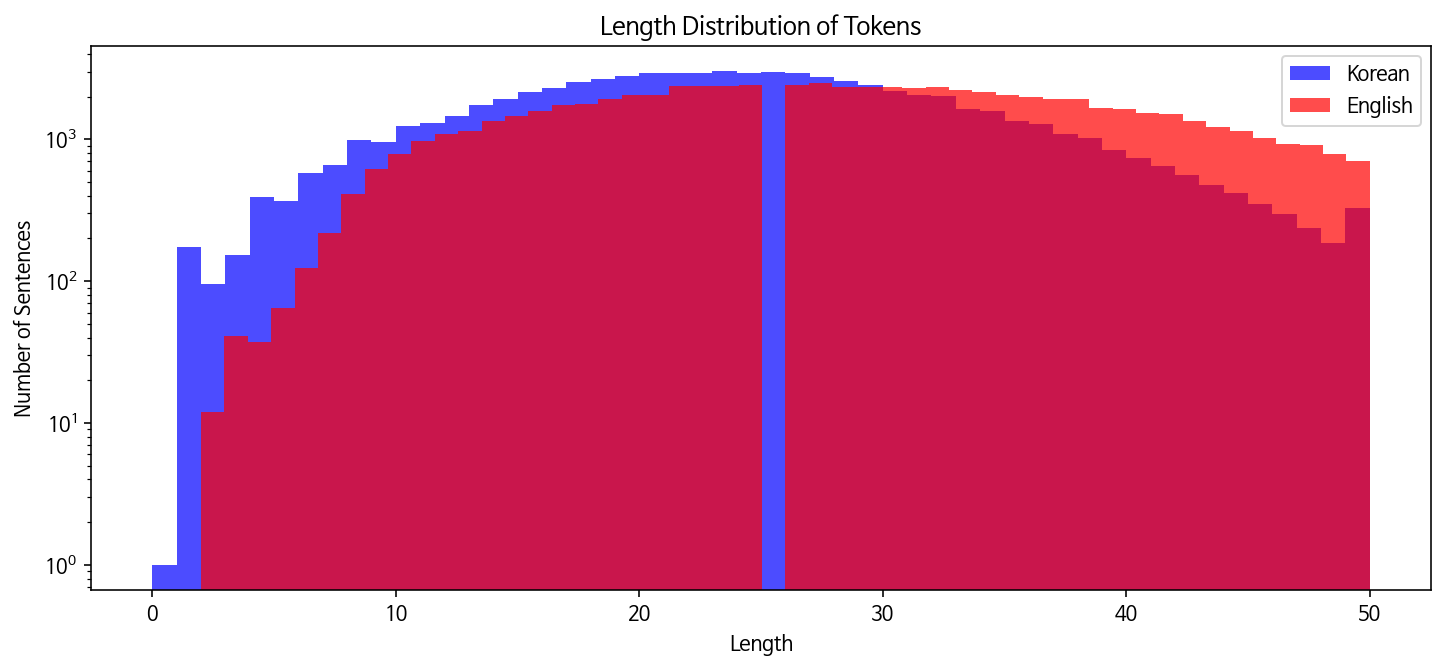

In [11]:
# 분포 확인용 시각화 함수
def plot_length_distribution(src_corpus, tgt_corpus):
    src_lengths = [len(sentence) for sentence in src_corpus]
    tgt_lengths = [len(sentence) for sentence in tgt_corpus]
    
    plt.figure(figsize=(12, 5))
    plt.hist(src_lengths, bins=50, alpha=0.7, color='b', label='Korean')
    plt.hist(tgt_lengths, bins=50, alpha=0.7, color='r', label='English')
    plt.yscale('log', nonpositive='clip')
    plt.title('Length Distribution of Tokens')
    plt.xlabel('Length')
    plt.ylabel('Number of Sentences')
    plt.legend()

    plt.show()

plot_length_distribution(src_corpus, tgt_corpus)


In [12]:
# 패딩처리를 완료하여 학습용 데이터 생성
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

### 결론
노드에서 언급하고 요구한 데이터 전처리가 모두 완료되었다.

주어진 함수와 과정을 최대한 반영한 결과물을 만들었다.


## 모델 생성

### 기반 컴포넌트 생성
- Positional Encoding
- MultiHead Attention
- Positionwise Feed Forward

In [13]:
def positional_encoding(pos, d_model):
    # 각 position 및 차원에 대한 각도를 계산하는 함수
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)
    
    # 각 position에 대해 d_model 차원의 각도 벡터를 계산하는 함수
    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    # [pos * d_model] 생성
    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    # 짝수 인덱스
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    # 홀수 인덱스
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    
    return sinusoid_table

In [14]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        
        # 각 Attention Head에서의 벡터 차원
        self.depth = d_model // self.num_heads
        
        # Q, K, V에 대한 linear layer 정의
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
        
        # Attention을 거친 결과를 다시 임베딩 차원으로 변환하기 위한 linear layer
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)
        
        # scale factor로 나눠줌
        scaled_qk = QK / tf.math.sqrt(d_k)
        
        # mask가 정의된 경우 mask 적용
        if mask is not None: 
            scaled_qk += (mask * -1e9)  
        
        # softmax를 통해 attention 확률 분포 계산
        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        # 최종적으로 attention을 V에 곱해줌
        out = tf.matmul(attentions, V)

        return out, attentions
            
    # Multi Head Attention을 위해 차원을 분할하는 함수
    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    # 분할된 차원을 원래대로 복구하는 함수
    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

        
    def call(self, Q, K, V, mask):
        # 각 Q, K, V에 linear transformation 적용
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        # 각 결과를 multi-head로 분할
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
        
        # Scaled Dot-Product Attention 실행
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
        
        # 분할된 Attention heads를 원래대로 복구
        out = self.combine_heads(out)
        # 최종적으로 Linear layer를 거침
        out = self.linear(out)
        
        # 결과와 attention weights 반환
        return out, attention_weights

In [15]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out

### 인코더/디코더 구현
- EncoderLayer
- DecoderLayer
- Encoder
- Decoder

In [32]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        
        # Multi-Head Attention 레이어
        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        # Position-wise Feed-Forward Network 레이어
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        # Layer Normalization
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        # 입력 x의 복사본을 residual에 저장
        residual = x
        # Layer Normalization 실행
        out = self.norm_1(x)
        # Multi-Head Attention 실행
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        # Dropout 실행
        out = self.dropout(out)
        # 원래 입력(residual)을 out에 더함
        out += residual
        
        
        """
        Position-Wise Feed Forward Network
        """
        # 현재 out의 복사본을 residual에 저장
        residual = out
        # 두 번째 Layer Normalization 실행
        out = self.norm_2(out)
        # Feed Forward Network 실행
        out = self.ffn(out)
        # Dropout 실행
        out = self.dropout(out)
        # 원래 입력(residual)을 out에 더함
        out += residual
        
        # 결과값과 Attention 값을 반환
        return out, enc_attn



In [17]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        
        # Masked Multi-Head Attention 및 Multi-Head Attention 레이어 생성
        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)
        
        # Position-wise Feed-Forward Network 레이어
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)
        
        # Layer Normalization
        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        # Masked Multi-Head Attention 실행
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        # Encoder-Decoder Multi-Head Attention 실행 
        # (query는 Decoder, key와 value는 Encoder의 결과)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        # Feed Forward Network 실행
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        # 결과값과 Attention 값을 반환
        return out, dec_attn, dec_enc_attn

In [18]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        # 인코더 내의 레이어 개수
        self.n_layers = n_layers
        # 지정된 개수만큼 인코더 레이어를 생성
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
        
        # 각 레이어의 어텐션 값들을 저장할 리스트
        enc_attns = list()
        for i in range(self.n_layers):
            # 각 인코더 레이어를 순차적으로 실행
            out, enc_attn = self.enc_layers[i](out, mask)
            # 각 레이어의 어텐션 값을 저장
            enc_attns.append(enc_attn)
        
        # 최종 출력과 모든 레이어의 어텐션 값을 반환
        return out, enc_attns

In [19]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        # 디코더 내의 레이어 개수
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        # 각 레이어의 어텐션 값들을 저장할 리스트
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            # 각 디코더 레이어를 순차적으로 실행
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)
            
            # 각 레이어의 어텐션 값을 저장
            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)
        
        # 최종 출력과 모든 레이어의 어텐션 값을 반환
        return out, dec_attns, dec_enc_attns

### 트랜스포머 구현

In [20]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        # 모델의 차원 수를 float 형태로 변환
        self.d_model = tf.cast(d_model, tf.float32)
        
        # 입력 및 출력 어휘 사이즈에 대한 임베딩 레이어 생성
        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)
        
        # 포지셔널 인코딩
        self.pos_encoding = positional_encoding(pos_len, d_model)
        
        self.dropout = tf.keras.layers.Dropout(dropout)
        
        # Encoder와 Decoder 클래스의 인스턴스 생성
        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)
        
        # 출력 레이어
        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        # 임베딩 파라미터를 공유하는지 여부
        self.shared = shared
        
        # 임베딩 파라미터를 공유하는 경우, 디코더 임베딩의 가중치를 출력 레이어에 설정
        if shared: 
            self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        # 입력의 시퀀스 길이
        seq_len = x.shape[1]
        # 임베딩 레이어를 통과
        out = emb(x)
        
        # 임베딩 파라미터를 공유하는 경우, d_model의 제곱근을 곱해줌
        if self.shared: 
            out *= tf.math.sqrt(self.d_model)
        
        # 포지셔널 인코딩을 더함
        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        # Dropout 적용
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        # 인코더와 디코더 입력에 임베딩 적용
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)
        
        # Encoder를 통과해 출력과 어텐션 값 얻음
        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        # Decoder를 통과해 출력과 어텐션 값들 얻음
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        # 디코더의 출력을 Dense 레이어에 통과시켜 로짓(logits)을 얻음
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

In [37]:
def generate_padding_mask(seq):
    #입력 시퀀스에서 패딩 토큰(0)의 위치를 확인하고,
    # 그 위치에 대해 마스크 값을 생성
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    # 인과성(cause-and-effect) 마스크를 생성
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    # 입력(source)과 출력(target)에 대한 패딩 마스크를 생성합니다.
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    # 디코더의 입력과 인코더의 출력 사이의 인과성 마스크를 생성
    # 인코더의 패딩 마스크와 결합하여 최종 디코더-인코더 마스크를 생성
    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)
    
    # 디코더의 입력에 대한 인과성 마스크를 생성
    # 디코더의 패딩 마스크와 결합하여 최종 디코더 마스크를 생성
    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    # 두 마스크 중 하나라도 적용되어야 할 경우
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

마스킹 시각화

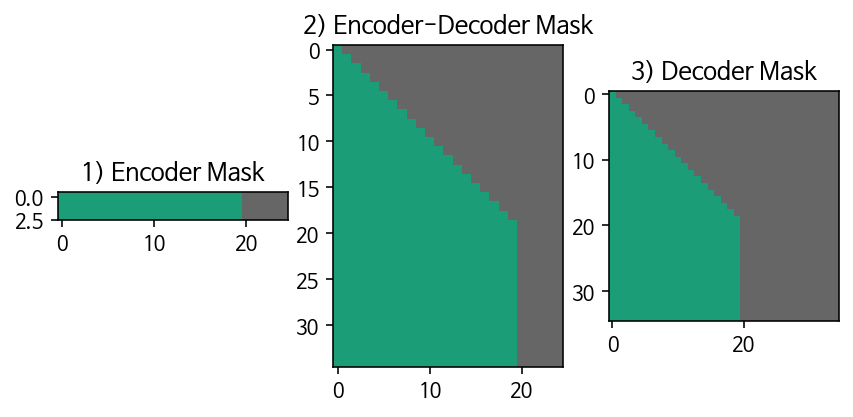

In [22]:
batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

## 학습 루틴 구성

### 옵티마이저 설정

In [23]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        '''
         d_model은 모델의 차원이고, 
         warmup_steps는 학습 초기에 학습률을 선형적으로 증가시키는 단계의 수
        '''
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        # 논문에 나온 수식 구현
        # lrate = d_model ** -0.5 * min(step_num ** -0.5, step_num * warmup_steps ** -1.5)
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

# 논문에서 설명한 파라미터 그대로 이용
learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

In [24]:
# loss 객체 생성
# from_logits=True는 예측값(pred)이 
# 확률 분포를 나타내는 로짓(즉, softmax 이전의 출력)으로 주어진다는 것을 의미
# 'reduction='none'은 손실을 바로 평균하거나 합하지 않고, 
# 모든 샘플에 대한 손실을 유지한다는 것

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    # 실제 값이 0인 위치를 찾아 이를 마스킹 -> 손실 계산에서 제외
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    # 모든 위치에서 손실을 계산
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    # 평균 손실을 반환
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

In [25]:
# Attention 시각화 함수

def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        sns.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [26]:
# 번역 생성 함수

def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    # 텍스트 전처리
    sentence = preprocess_sentence(sentence)
    
    # 문장을 토큰화
    pieces = src_tokenizer.encode_as_pieces(sentence)
    # 각 토큰을 정수로 인코딩
    tokens = src_tokenizer.encode_as_ids(sentence)
    
    # 인코딩된 문장을 패딩처리해서 모든 문장이 동일한 길이를 갖도록 함
    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens],
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')
    # 출력을 저장할 리스트 생성
    ids = []
    # 디코더의 초기 입력으로 시작 토큰 ID 설정
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    
    # 각 타임 스텝에 대해 인코더 및 디코더에 사용할 마스크 생성
    for i in range(dec_train.shape[-1]):
        # 마스크 생성
        enc_padding_mask, combined_mask, dec_padding_mask = \
        generate_masks(_input, output)

        # 예측치와 어텐션 가중치 가져옴
        predictions, enc_attns, dec_attns, dec_enc_attns =\
        model(_input, 
              output,
              enc_padding_mask,
              combined_mask,
              dec_padding_mask)
        
        # 예측치의 sooftmax를 계산하고 가장 높은 확률을 가진 토큰의 ID 선택
        predicted_id = \
        tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()

        # 예측된 토큰 ID가 종료 토큰 ID와 같다면
        if tgt_tokenizer.eos_id() == predicted_id:
            # 생성된 토큰 ID를 디코딩하고 결과를 반
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns
        
        # 예측된 토큰 ID를 저장하고, 이를 다음 타임스텝의 디코더 입력에 추가
        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    
    # 모든 스텝을 돌았음에도 종료토큰이 나오지 않는 경우
    # 지금까지 생성된 토큰 ID를 디코딩하여 반환
    result = tgt_tokenizer.decode_ids(ids)
    
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [27]:
# 번역 생성 및 Attention 시각화 결합

def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    # 번역 결과 생성
    pieces, result, enc_attns, dec_attns, dec_enc_attns = \
    evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    # 시각화
    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

In [28]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행
    with tf.GradientTape() as tape:
        # 예측값을 생성 및 어텐션 값 가져옴
        predictions, enc_attns, dec_attns, dec_enc_attns = \
        model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        # loss 계산
        loss = loss_function(gold, predictions[:, :-1])

    # 그래디언트를 계산하고, 그래디언트를 적용하여 파라미터를 업데이트
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns


In [29]:
# 하이퍼파라미터 설정
BATCH_SIZE = 64
EPOCHS = 20
n_layers = 2
d_model = 512
n_heads = 8
d_ff = 2048
dropout = 0.2
pos_len = 200

# Transformer 객체 생성
transformer = Transformer(n_layers=n_layers,
                          d_model=d_model,
                          n_heads=n_heads,
                          d_ff=d_ff,
                          src_vocab_size=SRC_VOCAB_SIZE,
                          tgt_vocab_size=TGT_VOCAB_SIZE,
                          pos_len=pos_len,
                          dropout=dropout,
                          shared=True)


In [30]:
# 학습
import random

examples = [
            "오바마는 대통령이다.",
            "시민들은 도시 속에 산다.",
            "커피는 필요 없다.",
            "일곱 명의 사망자가 발생했다."
]

# 각 에폭에서의 평균 손실을 추적하기 위한 리스트
losses = []

for epoch in range(EPOCHS):
    # 총 loss
    total_loss = 0
    
    # 배치 크기 단위로 훈련 데이터 인덱스를 생성하고 무작위로 섞는다.
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)
    
    # 미니배치 학습 진행
    for (batch, idx) in enumerate(t):
        # 학습 루틴 호출
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)
        
        # 배치 손실 추가
        total_loss += batch_loss
        
        # tqdm 업데이트
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))
    
    # 최종 손실 추가
    losses.append(total_loss.numpy() / (batch + 1))
    
    # 해당 에포크에 대한 번역 결과 출력
    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city of the city s .
Input: 커피는 필요 없다.
Predicted translation: he said he was not to the very good .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the bomb was killed in the southern city of the death toll .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city of high .
Input: 커피는 필요 없다.
Predicted translation: it s not a little little .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: four people died sunday in the death toll .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president elect .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city of urban city .
Input: 커피는 필요 없다.
Predicted translation: it s not just . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a popular choice for the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is a city of . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .
Input: 커피는 필요 없다.
Predicted translation: there s no alternative alternative alternative .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: the death toll was reported saturday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: the city is the highly mixed .
Input: 커피는 필요 없다.
Predicted translation: there is no alternative .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and were wounded .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: the president is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the city where they are .
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and seven others were wounded .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: on august , the city of xiang .
Input: 커피는 필요 없다.
Predicted translation: no coffee needs to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and wounded in the ministry of civil affairs .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re on the street .
Input: 커피는 필요 없다.
Predicted translation: there needs to be no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people have died in the day of the crash .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the latest attempt to fill president elect barack obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are the cities of a city .
Input: 커피는 필요 없다.
Predicted translation: there is no need to be an oddball .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , seven crew members .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president elect barack obama is president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they re only a street corner .
Input: 커피는 필요 없다.
Predicted translation: there needs coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven crew members on sunday were killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they had the cities of the city .
Input: 커피는 필요 없다.
Predicted translation: there needs to be no ways at cup coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , with seven others .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: president elect barack obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stayed in the city .
Input: 커피는 필요 없다.
Predicted translation: there is needed therapy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the monday bombing of seven people .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president in texas .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are cities in the city .
Input: 커피는 필요 없다.
Predicted translation: there need to be coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed in the day .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a national aide to president elect obama .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are in one of the city s world cup .
Input: 커피는 필요 없다.
Predicted translation: there need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , including seven deaths .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are only the street .
Input: 커피는 필요 없다.
Predicted translation: there need to be no needy .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they are three cities .
Input: 커피는 필요 없다.
Predicted translation: there need to be no need for coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed , reported .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is the president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they come on the town .
Input: 커피는 필요 없다.
Predicted translation: there need to be about .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people were killed and wounded crew members .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a friendly president .
Input: 시민들은 도시 속에 산다.
Predicted translation: and they lived in the town .
Input: 커피는 필요 없다.
Predicted translation: there need to be needed ways to coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven crew members were killed , according to the ministry of civil defense and seven who were wounded .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they ve become a street in the town .
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee at coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven crew deaths on seven deaths reported tuesday .


  0%|          | 0/1128 [00:00<?, ?it/s]

Input: 오바마는 대통령이다.
Predicted translation: obama is president of the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stay in the town .
Input: 커피는 필요 없다.
Predicted translation: there need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people on tuesday were killed with seven deaths .


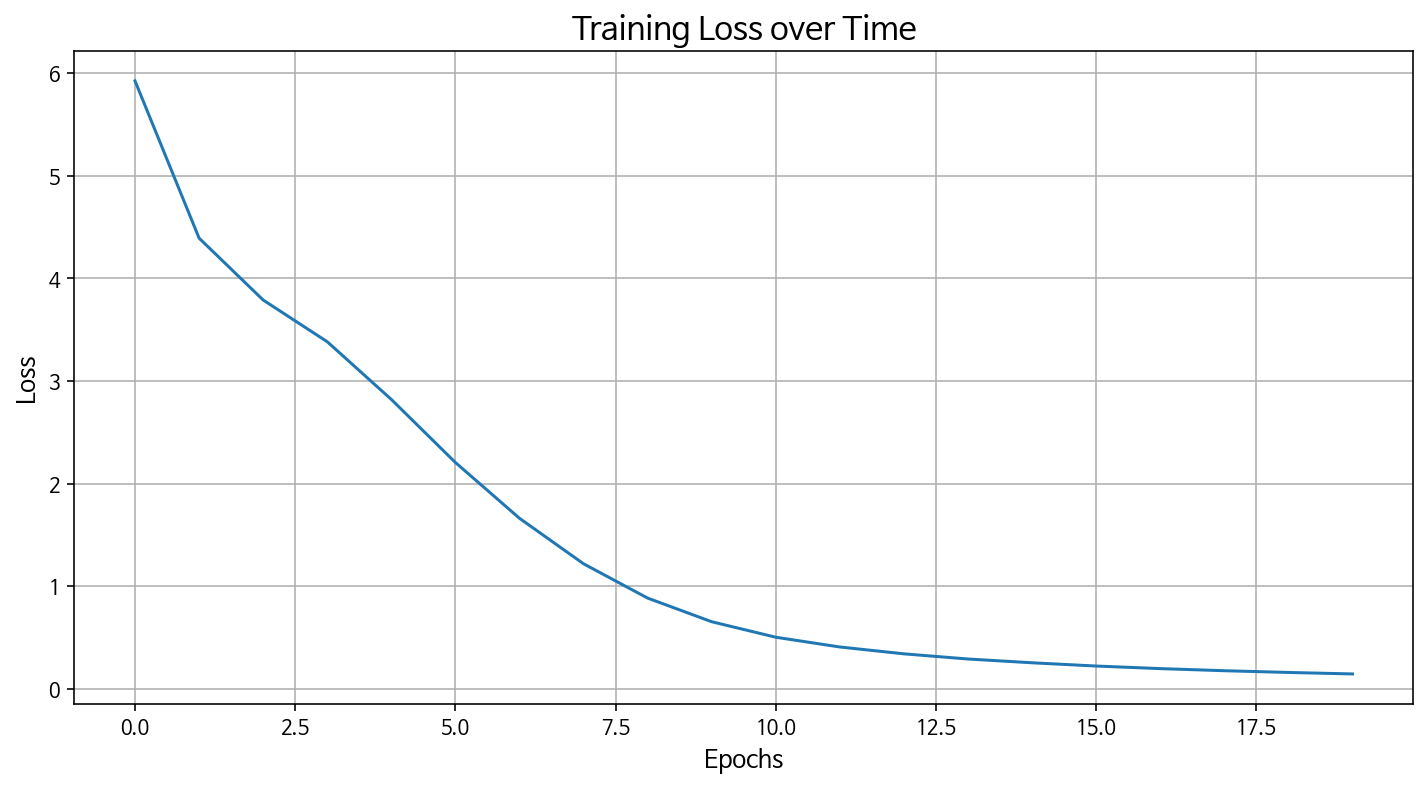

In [33]:
# loss 시각화
plt.figure(figsize=(12, 6))

plt.plot(losses)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training Loss over Time", fontsize=16)
plt.grid(True)
plt.show()

### 결론

모델의 학습과 추론 과정이 정상적으로 진행됬다.
loss 수치가 점점 감소하는 추세를 보였고, 결과도 점점 개선된 것을 볼 수 있다.

다만, 아쉬운 것은 아래를 보면 윗쪽은 epoch 19의 결과이고, 
아래는 20번째 학습 결과인데, 번역 결과가 조금 아쉬운 것이 보인다.

```
>>Epochs19<<
Input: 오바마는 대통령이다.
Predicted translation: obama is a president .
Input: 시민들은 도시 속에 산다.
Predicted translation: they ve become a street in the town .
Input: 커피는 필요 없다.
Predicted translation: there is no need for coffee at coffee .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven crew deaths on seven deaths reported tuesday .

>>Epochs20<<
Input: 오바마는 대통령이다.
Predicted translation: obama is president of the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stay in the town .
Input: 커피는 필요 없다.
Predicted translation: there need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people on tuesday were killed with seven deaths .
```

먼저 "오바마는 대통령이다."라는 문장에서 완벽한 결과를 보여줬던 반면 이후에 이상한 수식어 붙어서 애매해져 버렸다.

"커피는 필요 없다."에서는 아에 coffee가 사라지기도 했다.

이를 통해 나는 무작정 epochs를 늘리기보다 
적절한 시점에서 중단하는 방법을 선택했다.

참고를 위해 50번 학습시켜서 축적한 loss의 시각화 자료를 첨부하겠다.
![](https://github.com/crlotwhite-mirror/AiffelOnline4/blob/main/Going_Deeper_NLP/GD_NLP_5/output.png?raw=true)

## 결과 확인

### 텍스트

In [35]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=False)

Input: 오바마는 대통령이다.
Predicted translation: obama is president of the country .
Input: 시민들은 도시 속에 산다.
Predicted translation: they stay in the town .
Input: 커피는 필요 없다.
Predicted translation: there need to be needed .
Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people on tuesday were killed with seven deaths .


### 어텐션 맵

Input: 오바마는 대통령이다.
Predicted translation: obama is president of the country .
Encoder Layer 1


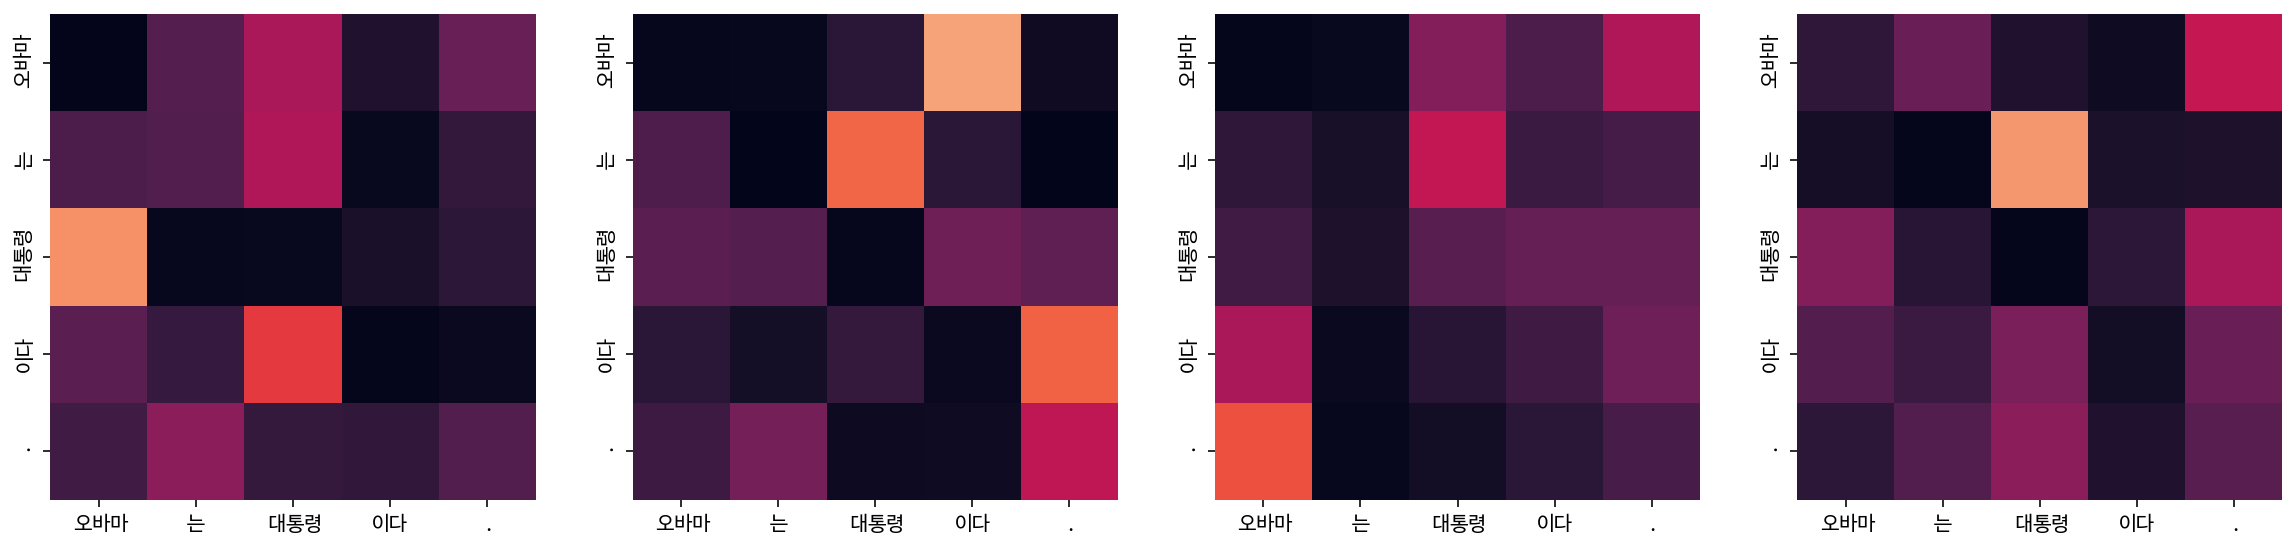

Encoder Layer 2


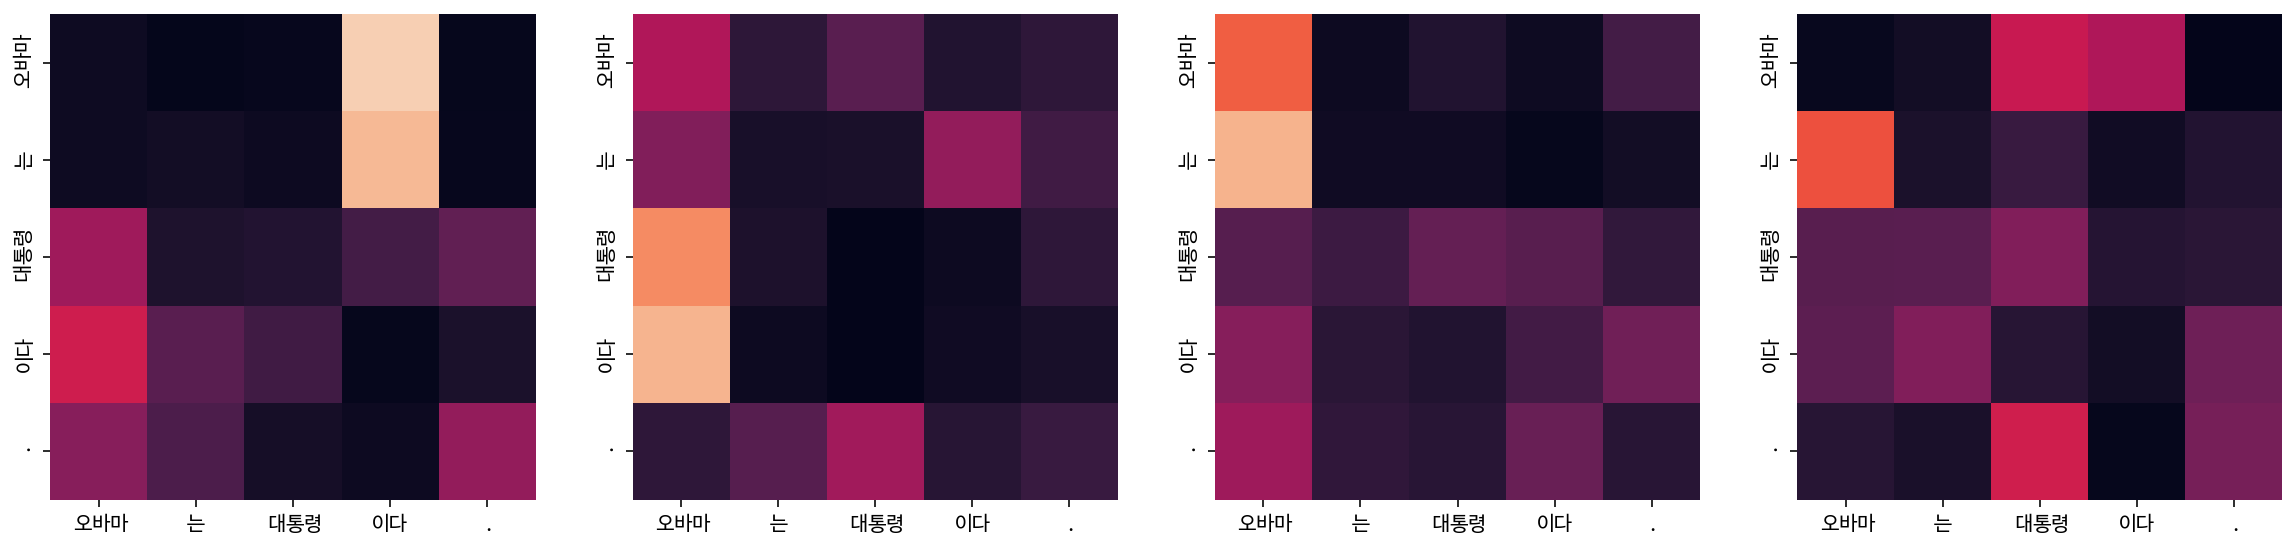

Decoder Self Layer 1


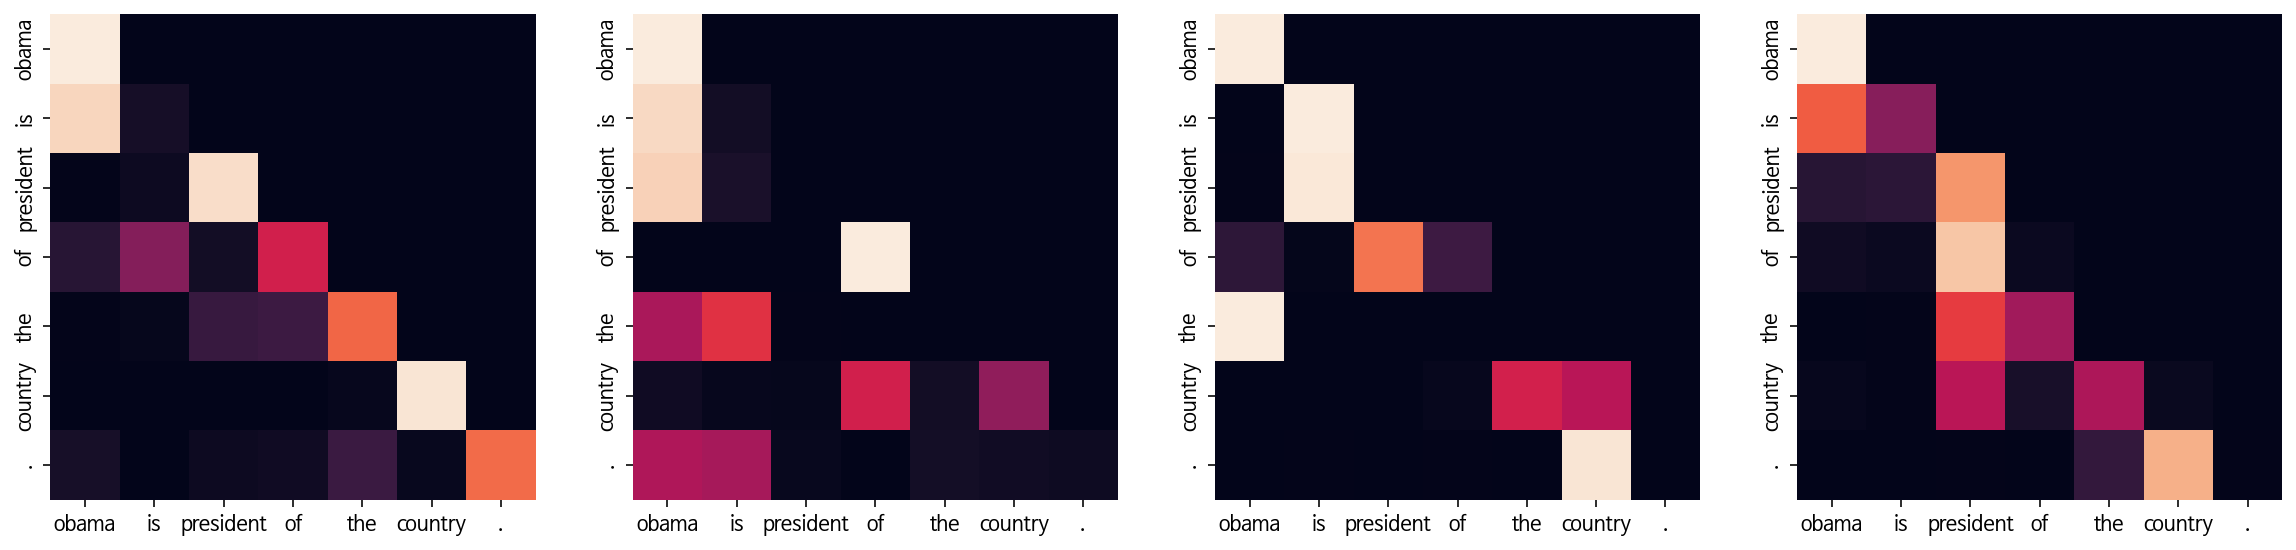

Decoder Src Layer 1


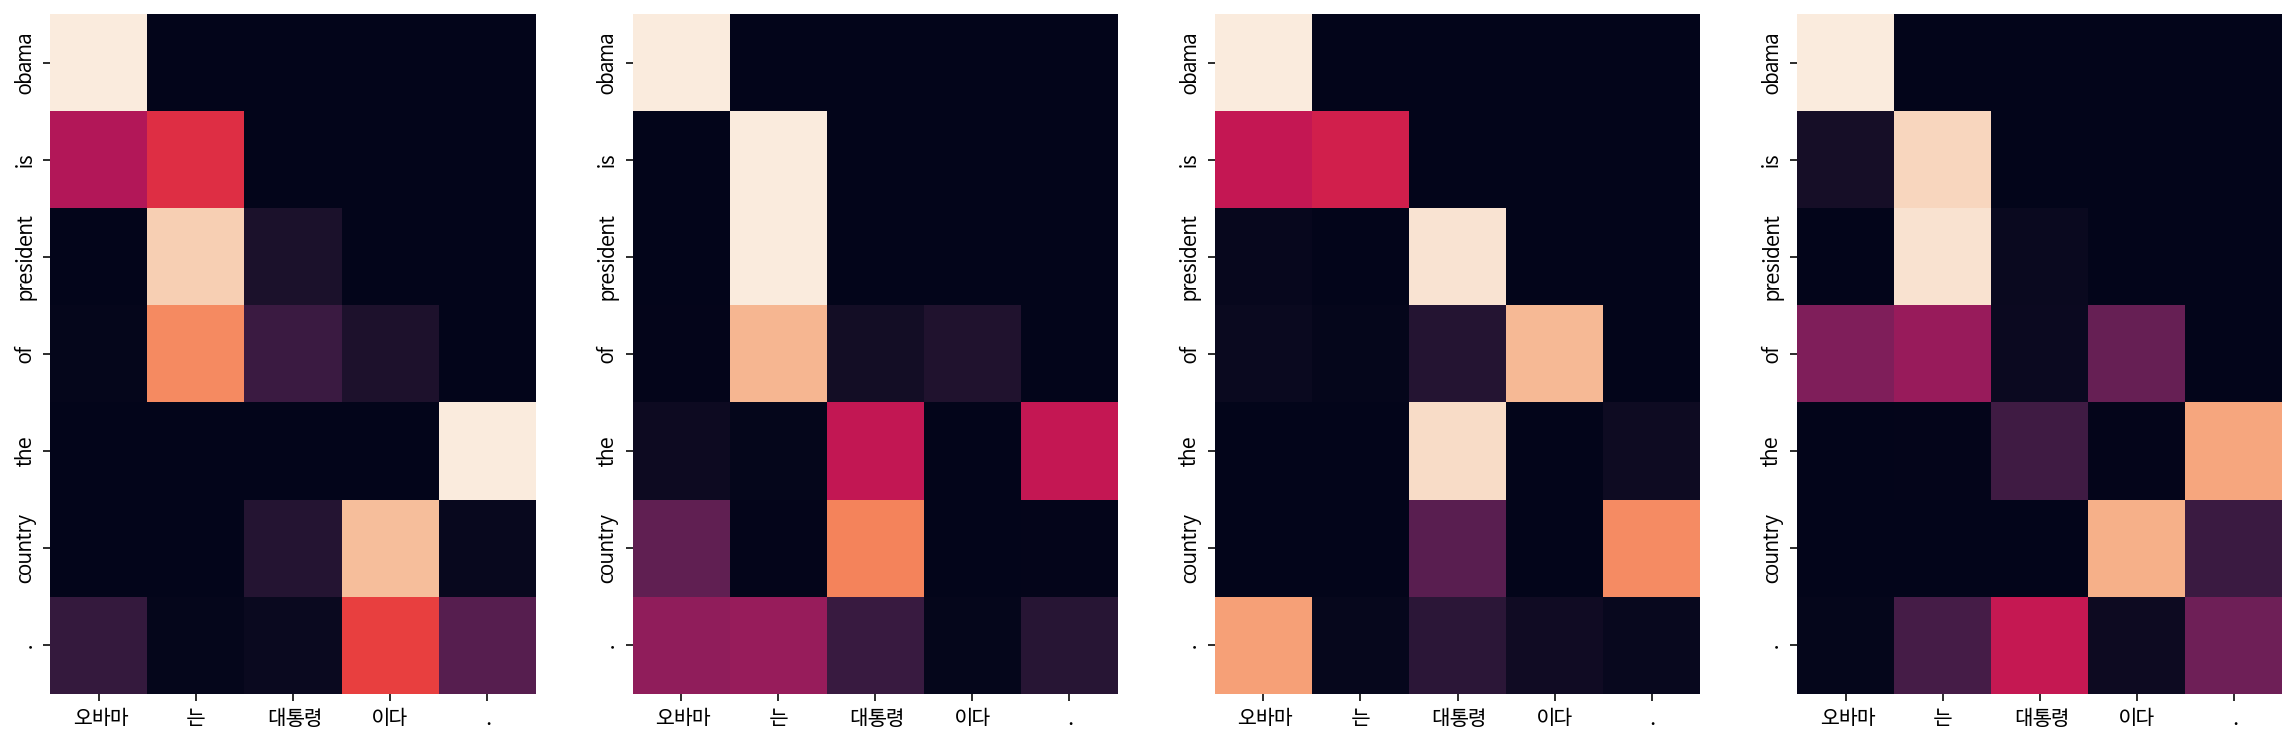

Decoder Self Layer 2


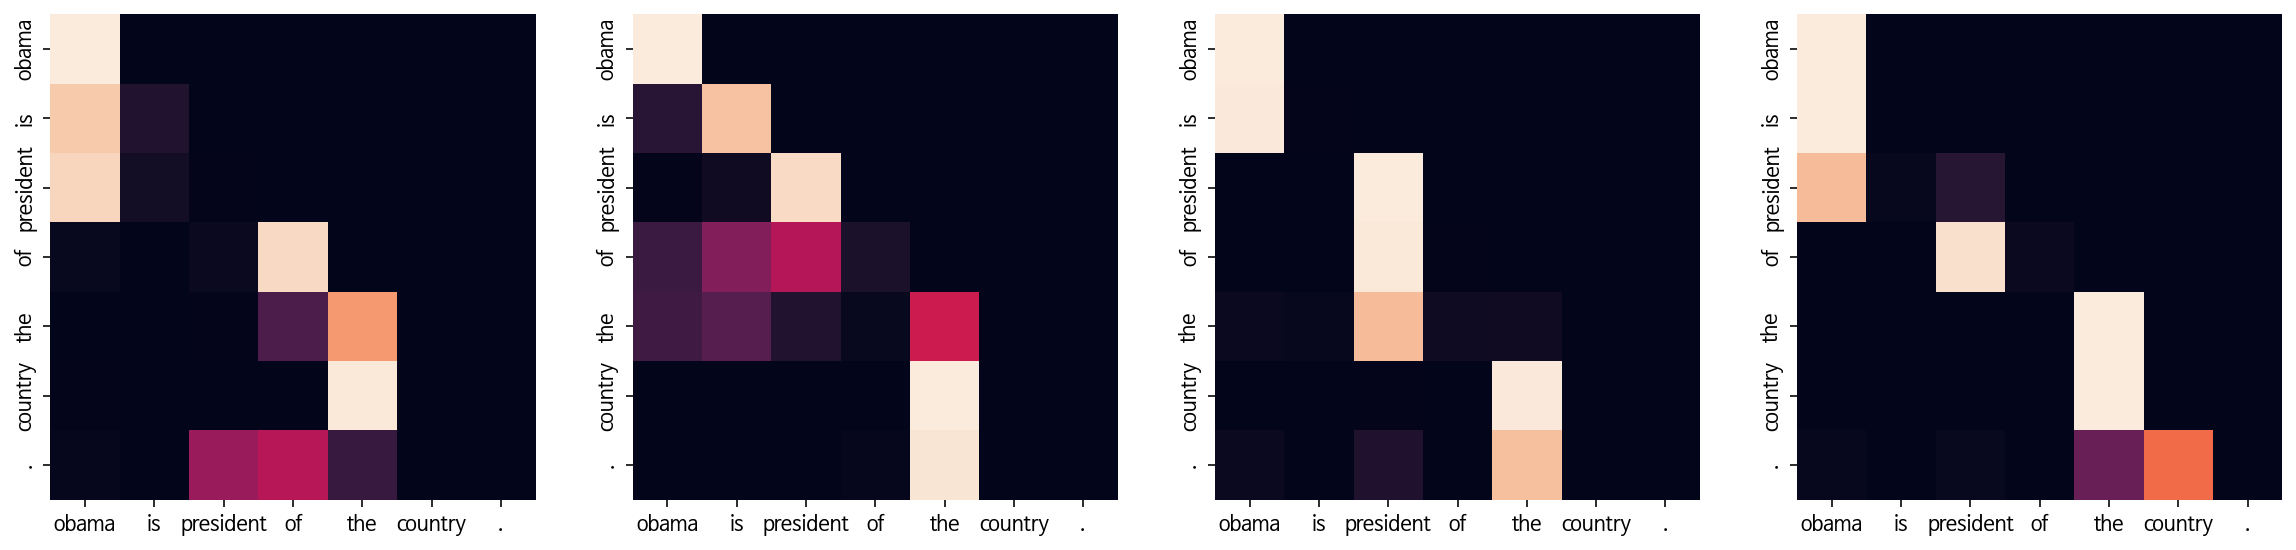

Decoder Src Layer 2


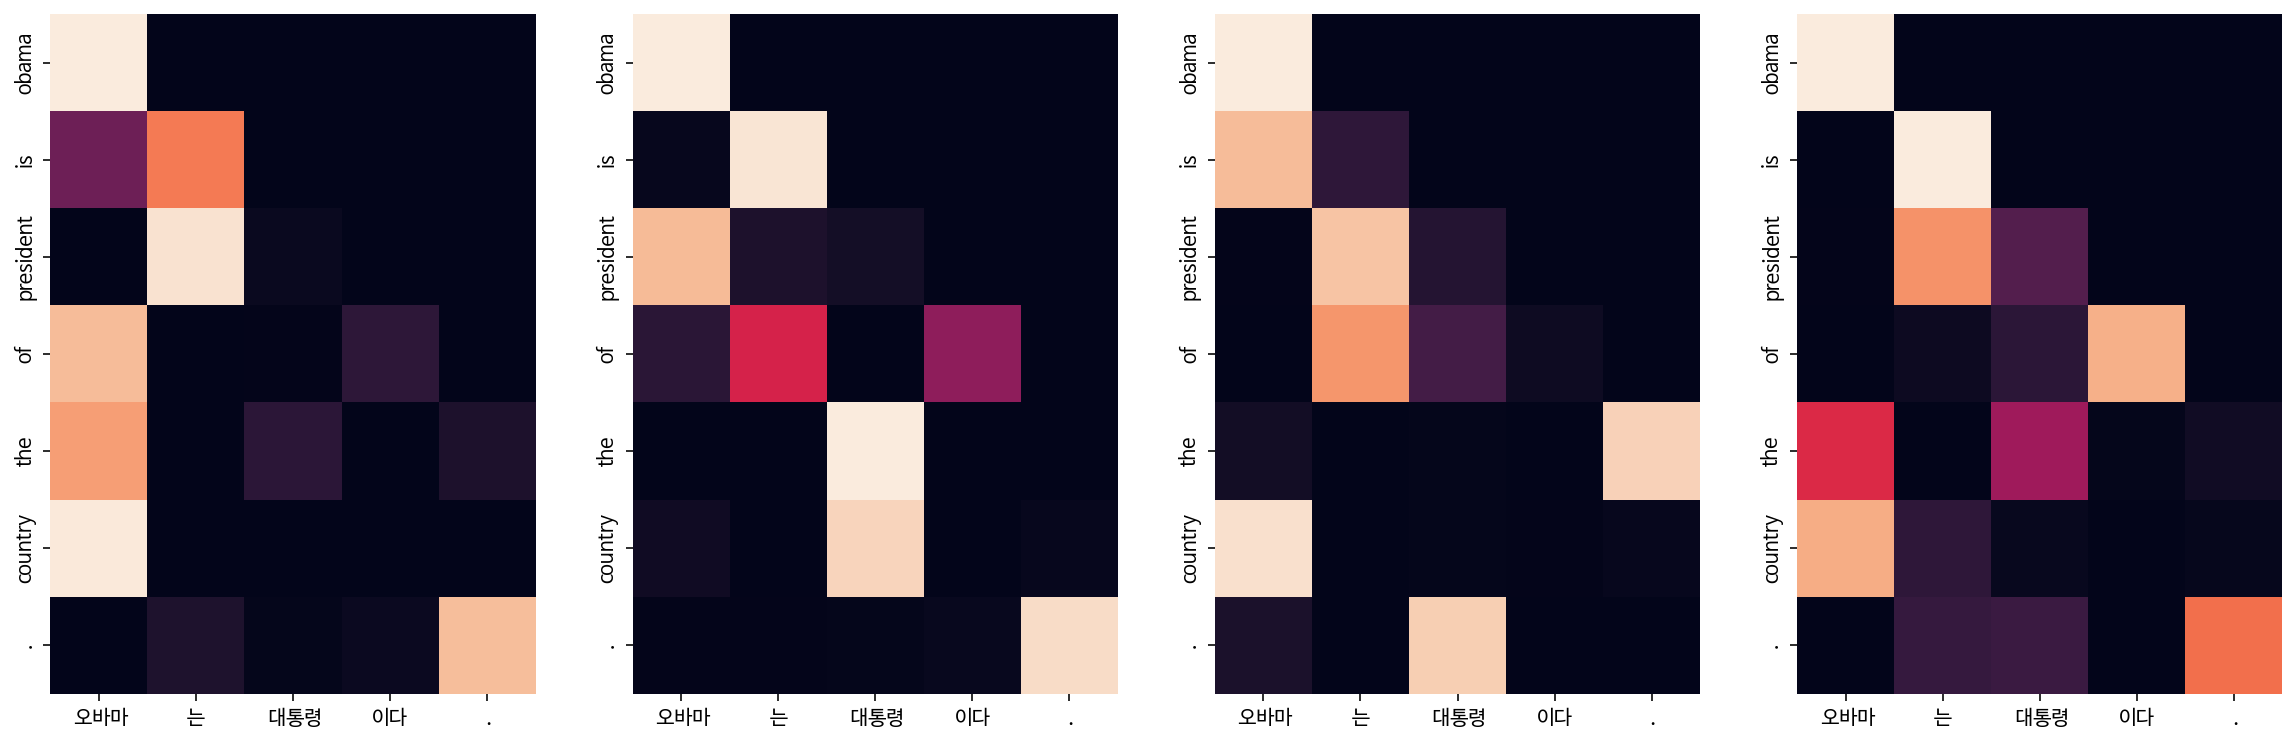

Input: 시민들은 도시 속에 산다.
Predicted translation: they stay in the town .
Encoder Layer 1


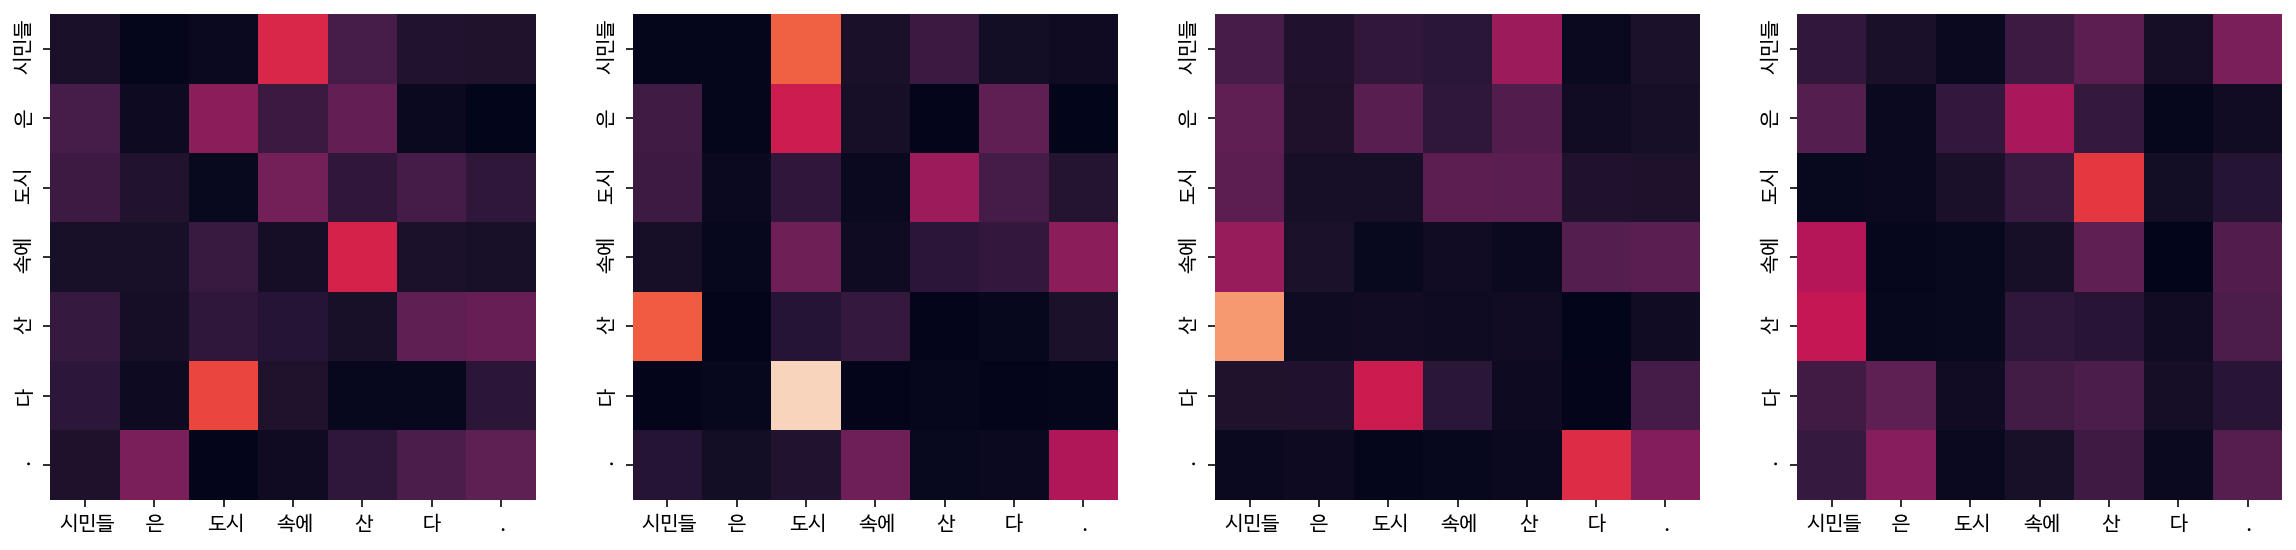

Encoder Layer 2


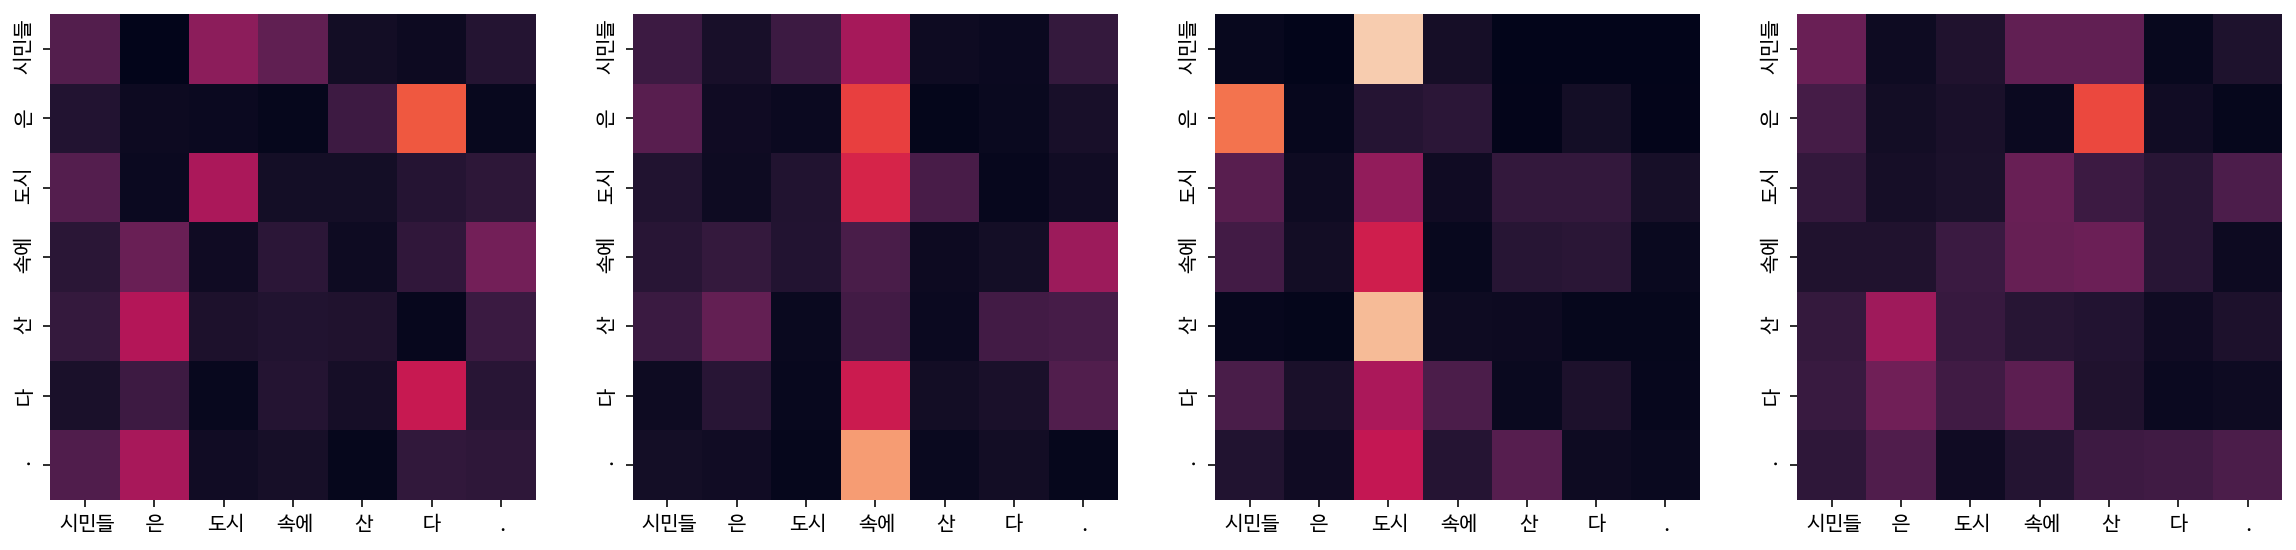

Decoder Self Layer 1


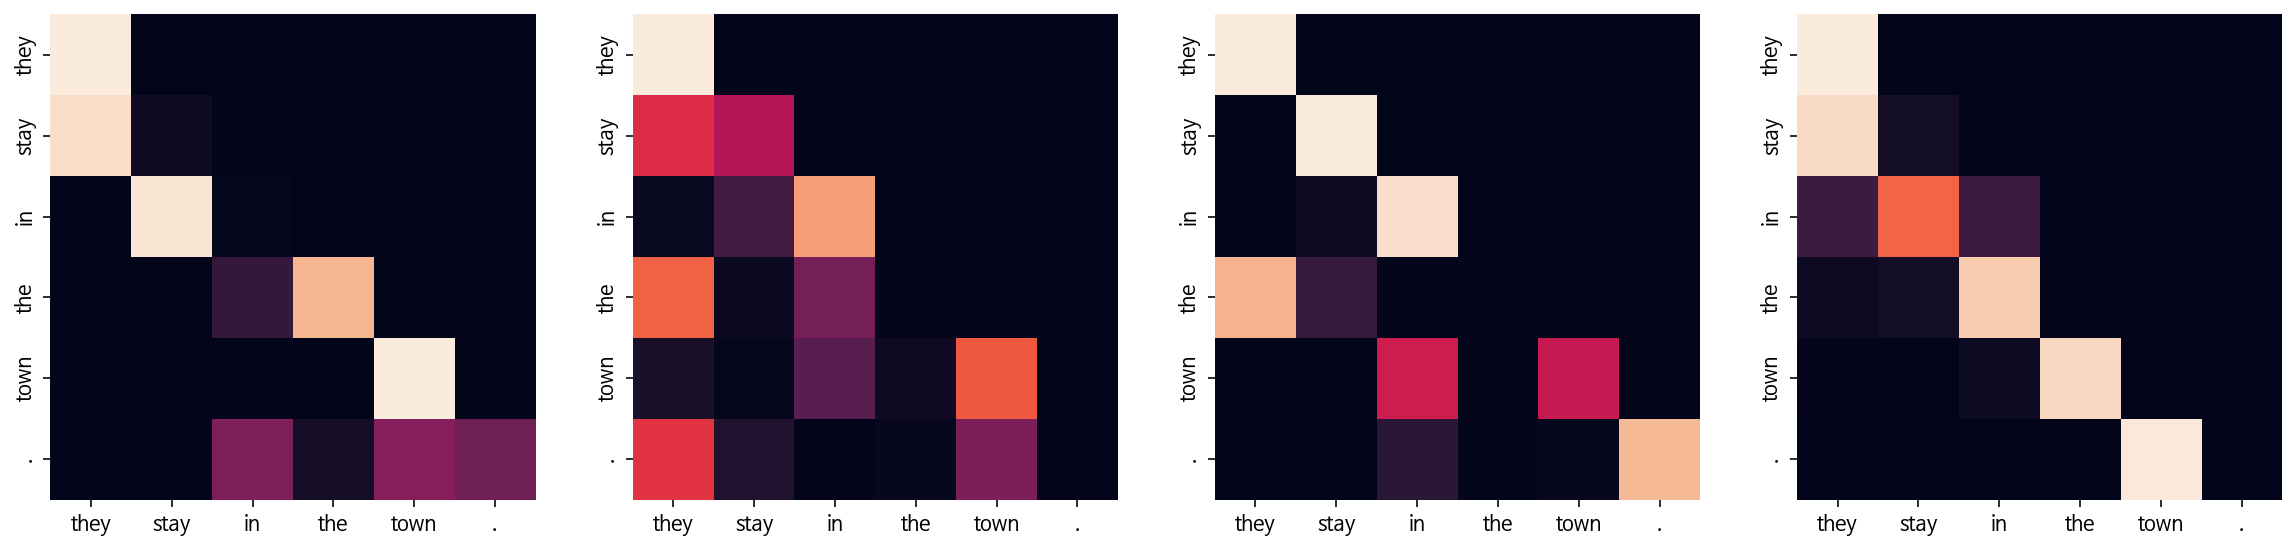

Decoder Src Layer 1


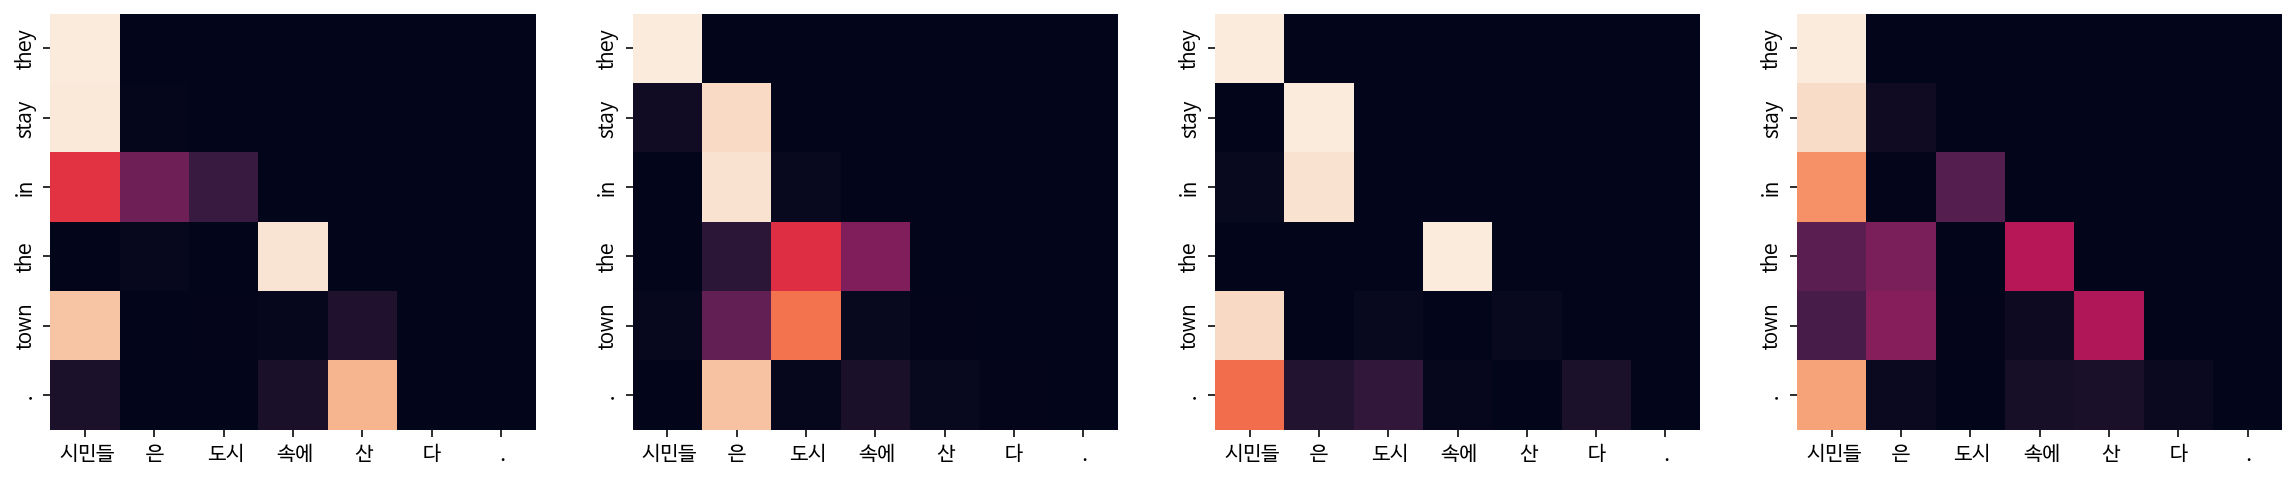

Decoder Self Layer 2


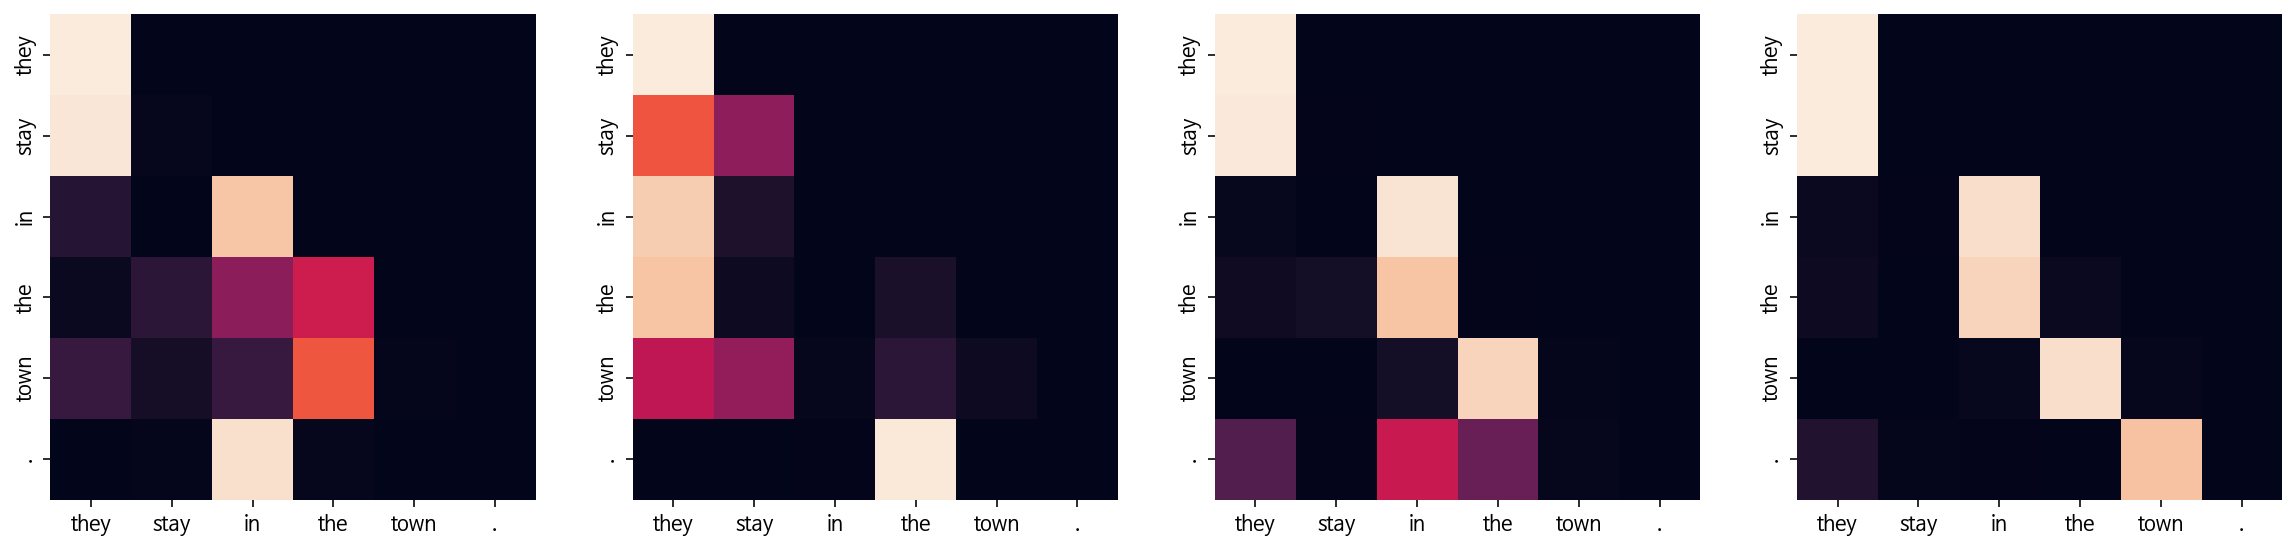

Decoder Src Layer 2


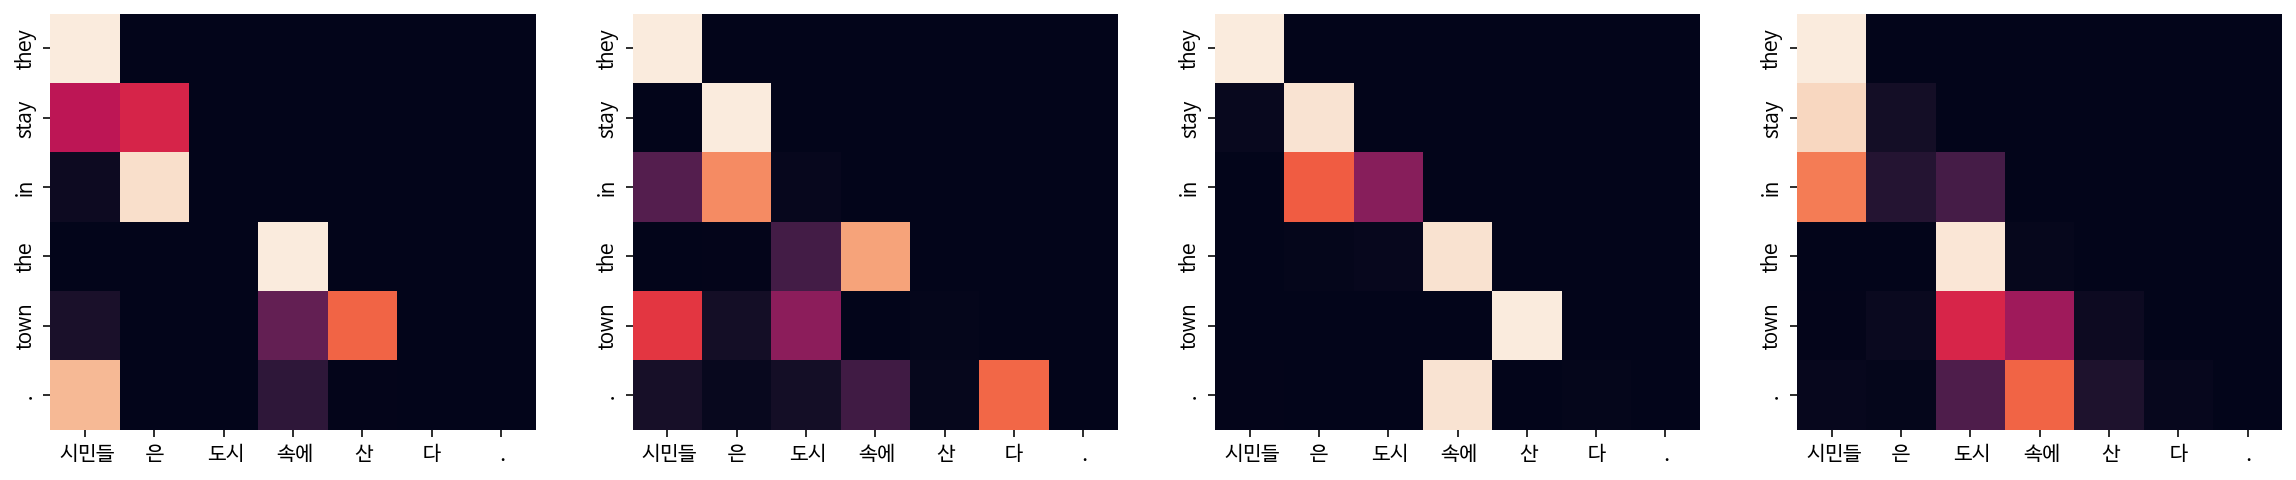

Input: 커피는 필요 없다.
Predicted translation: there need to be needed .
Encoder Layer 1


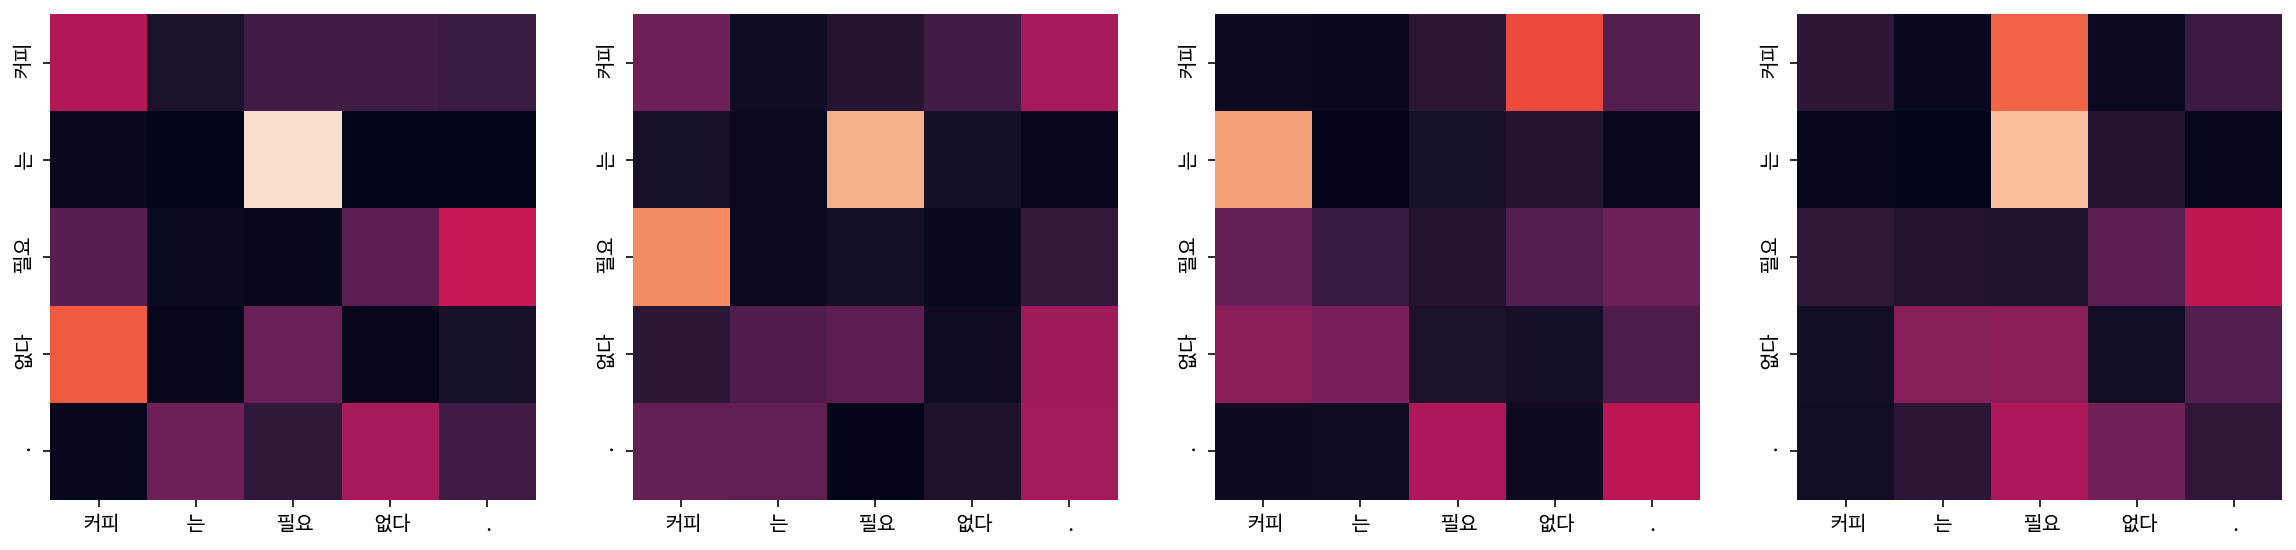

Encoder Layer 2


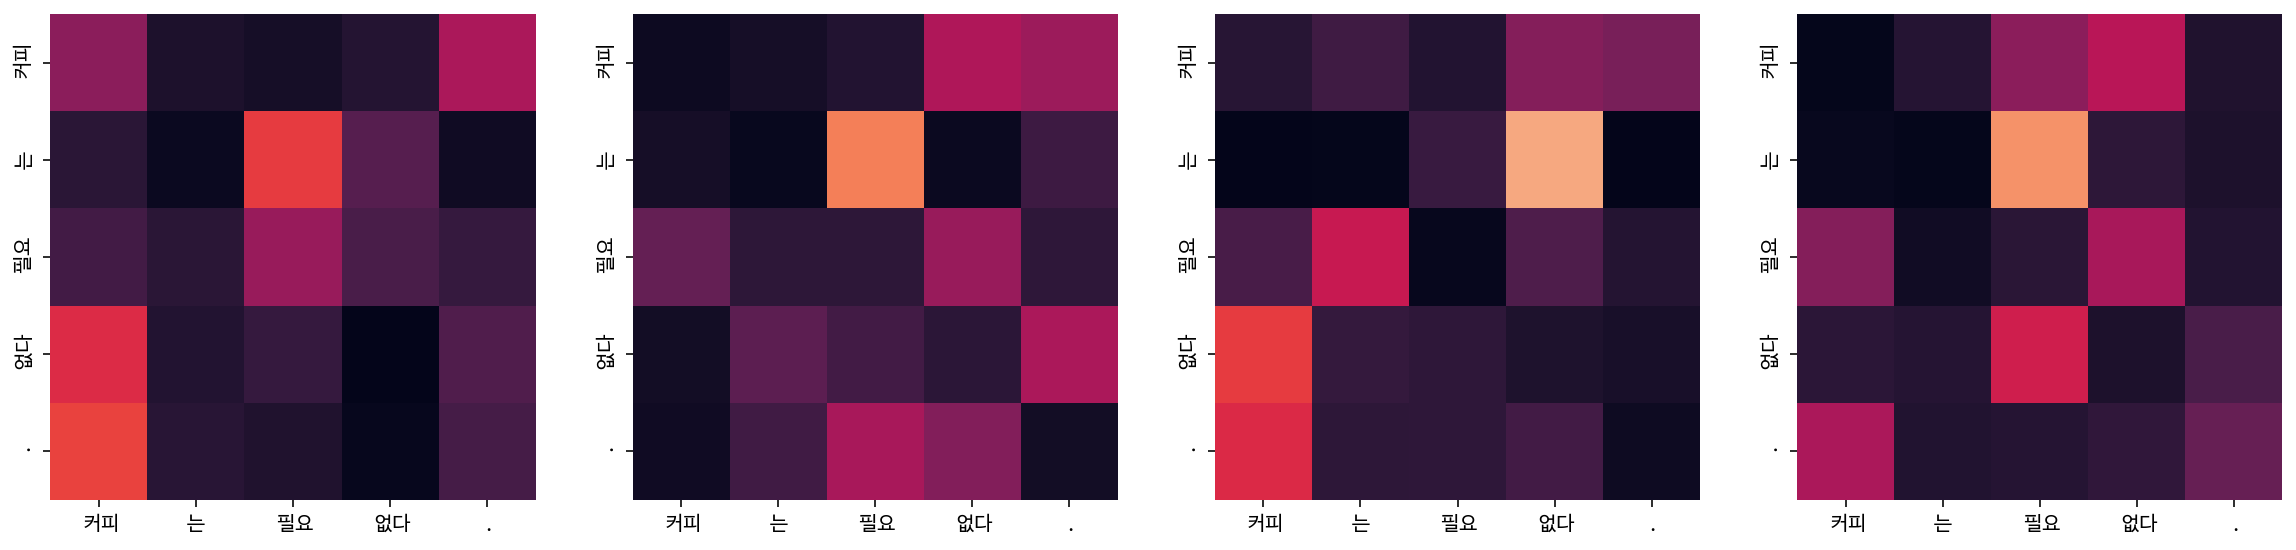

Decoder Self Layer 1


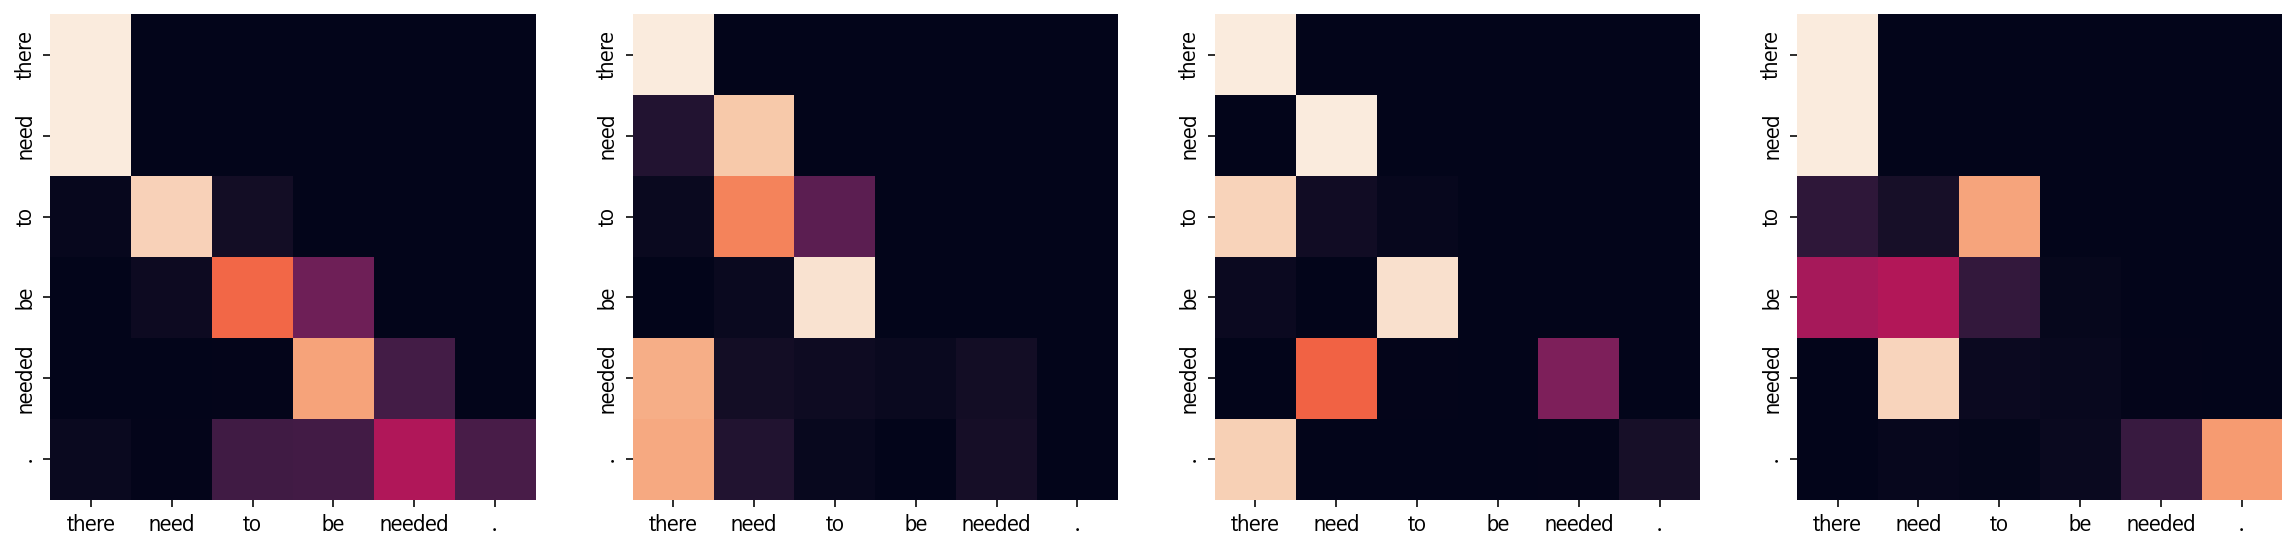

Decoder Src Layer 1


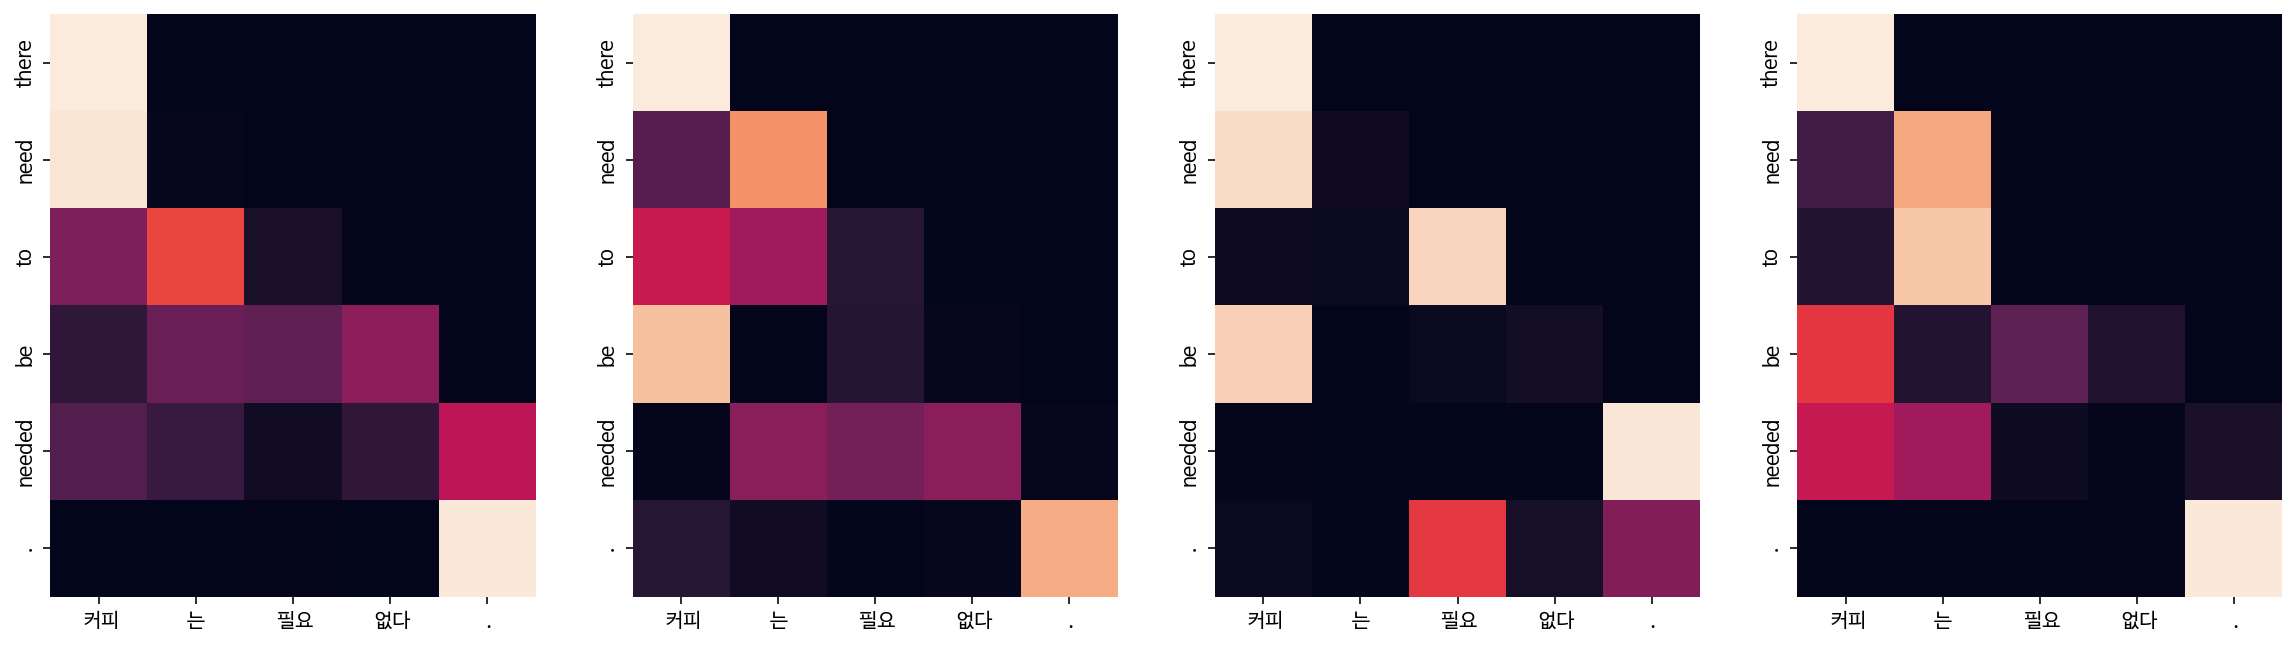

Decoder Self Layer 2


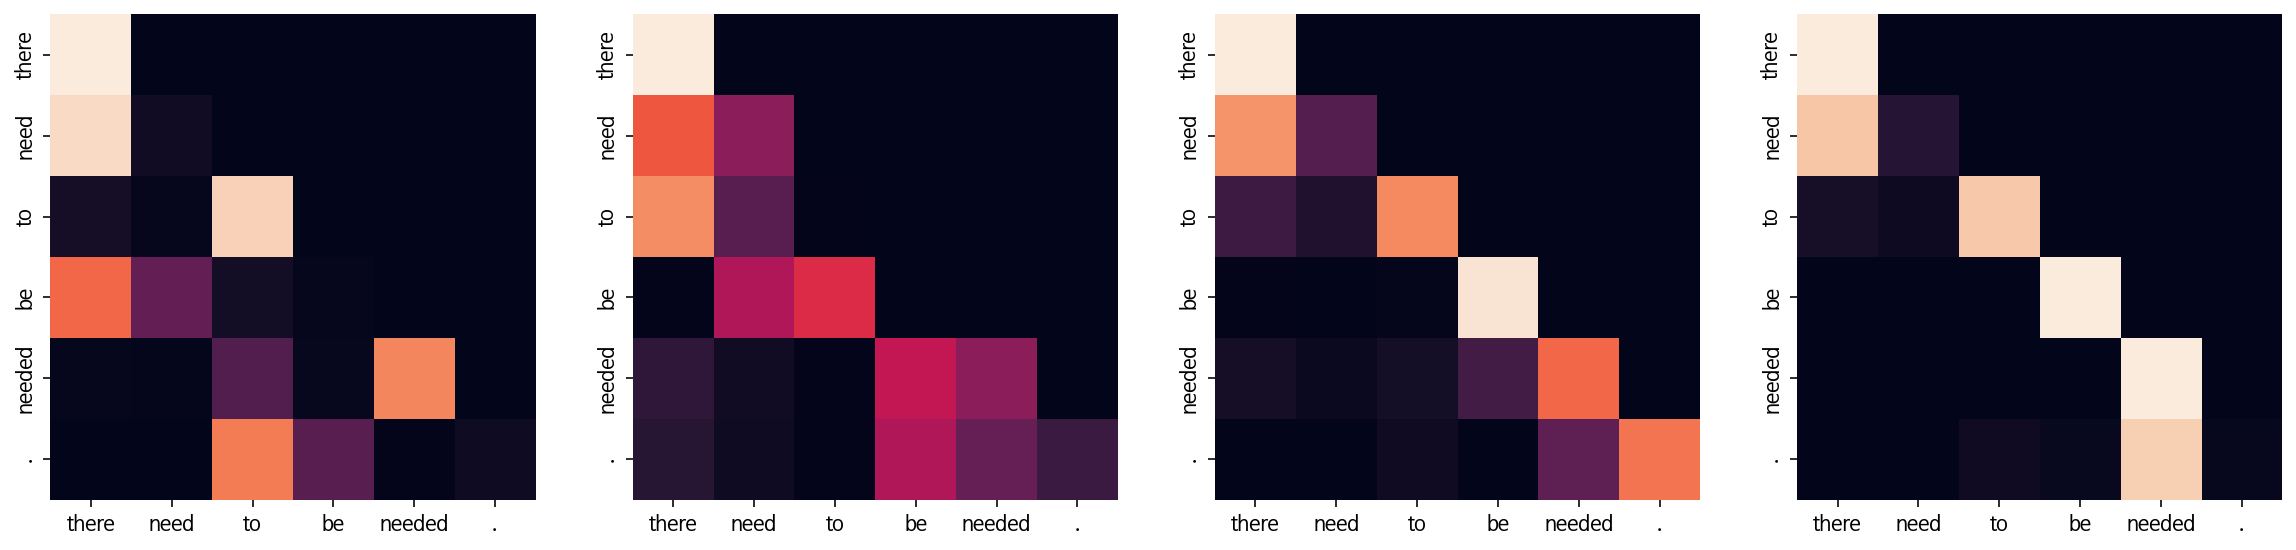

Decoder Src Layer 2


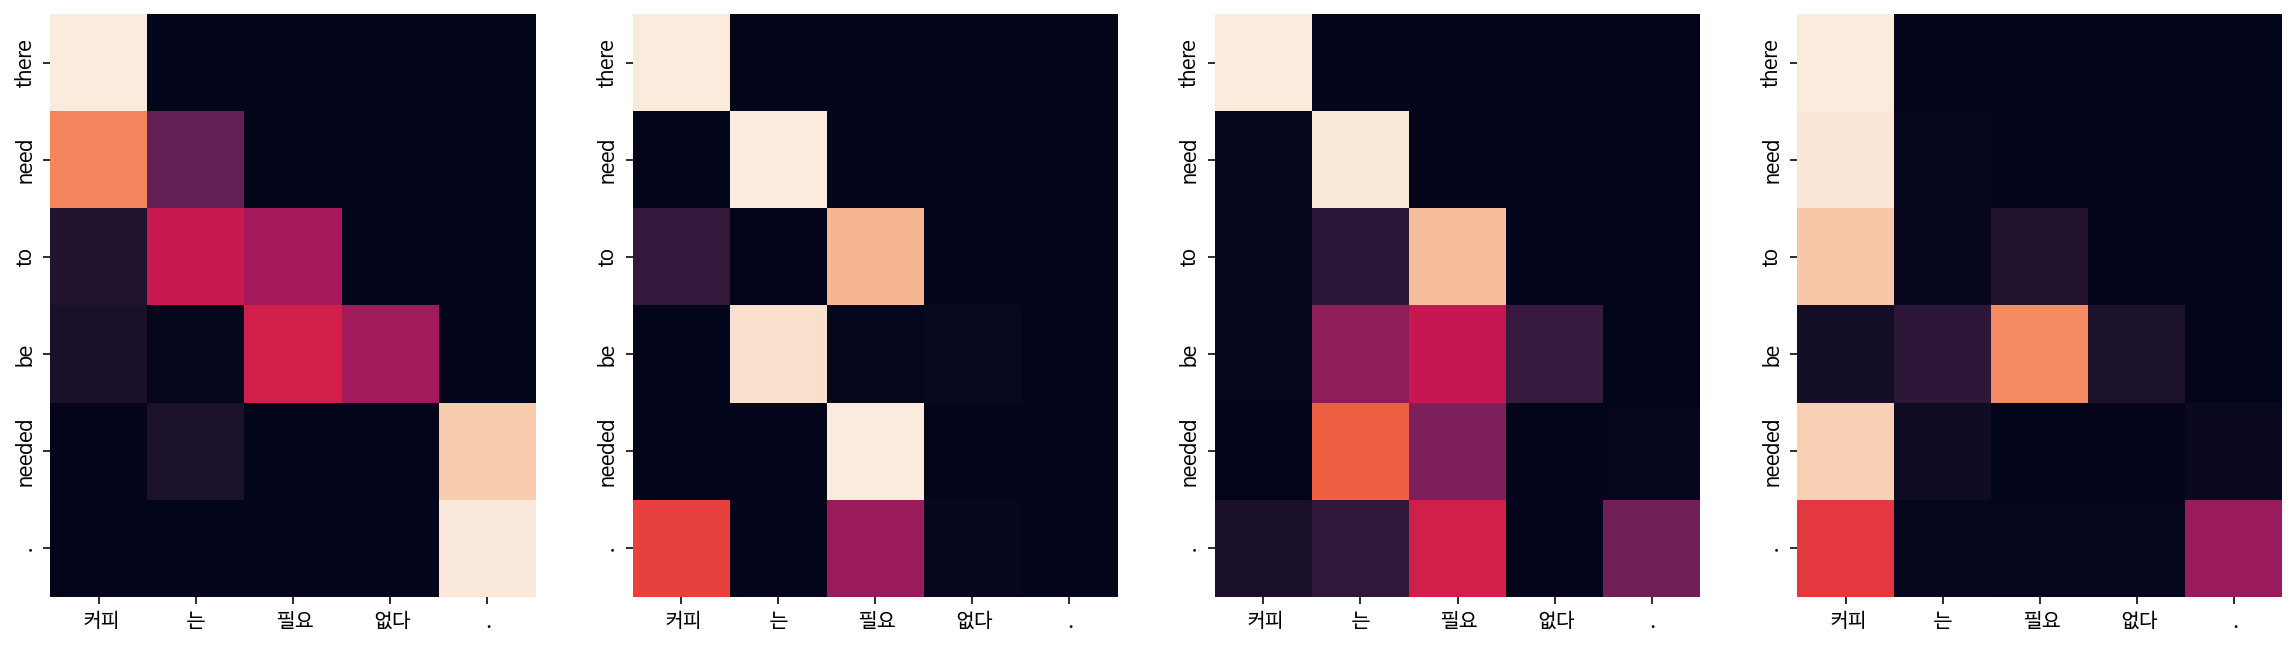

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people on tuesday were killed with seven deaths .
Encoder Layer 1


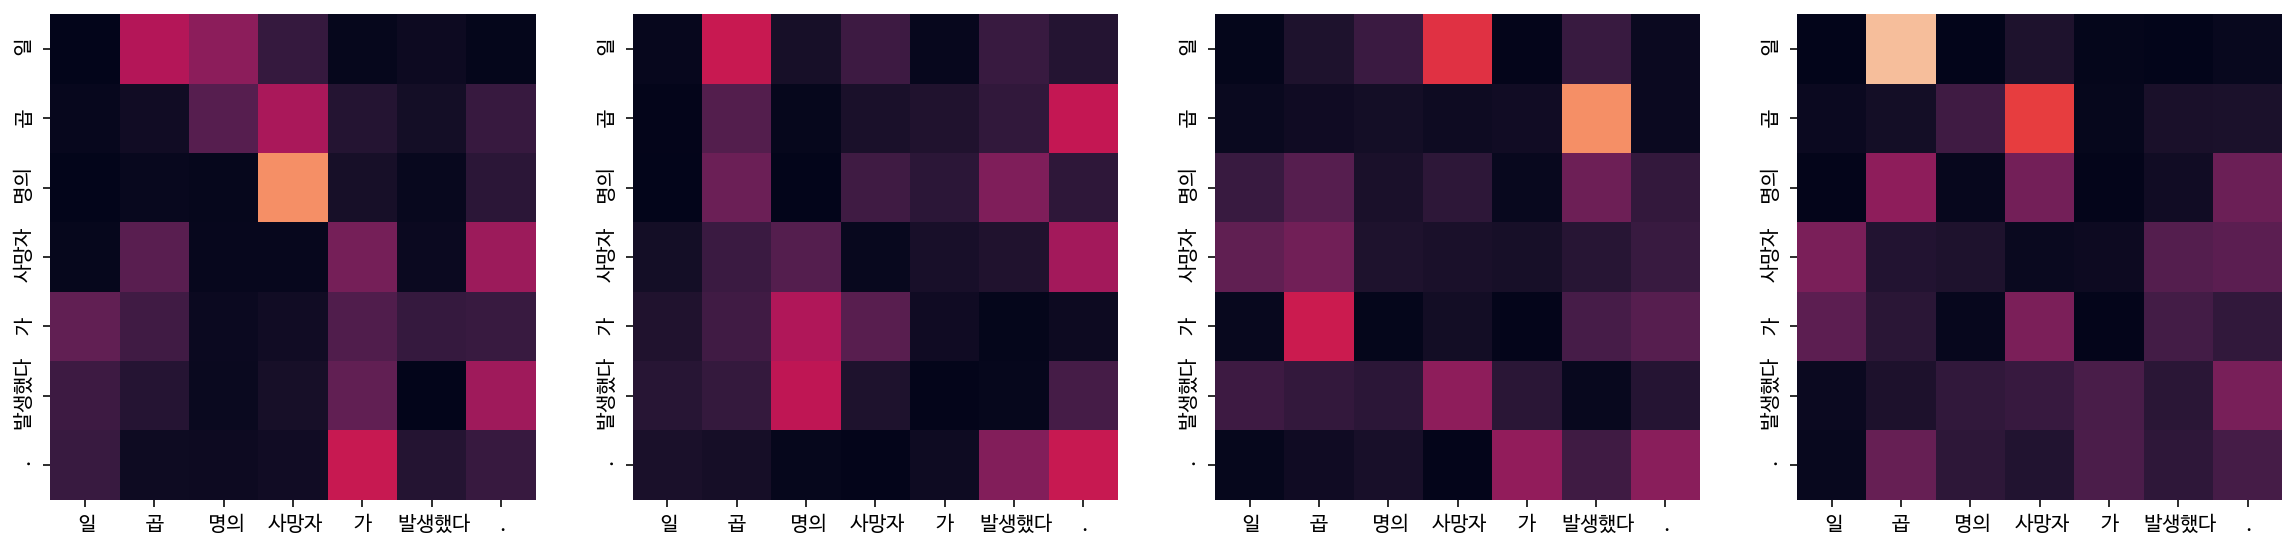

Encoder Layer 2


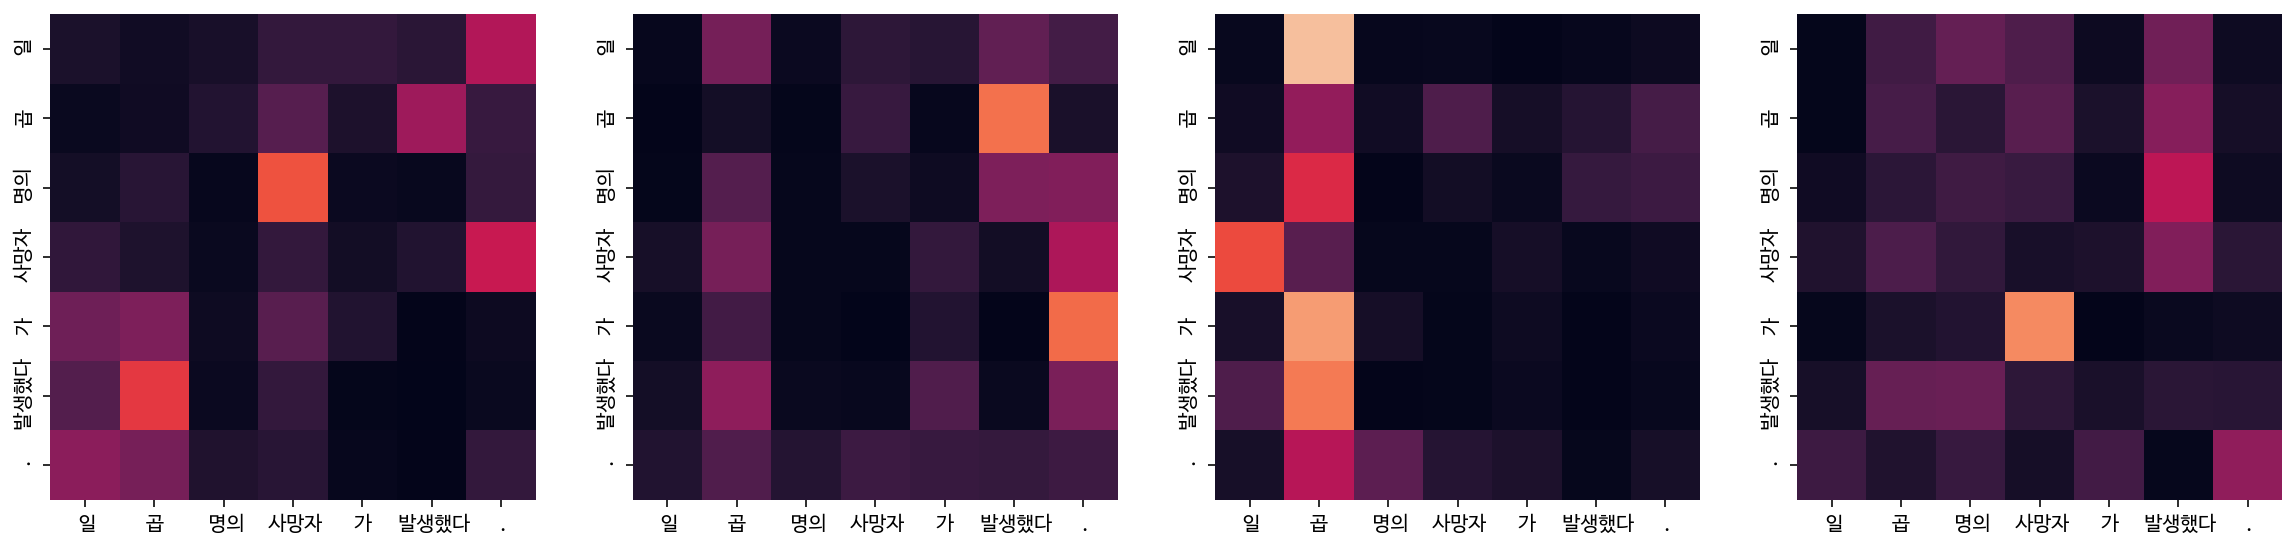

Decoder Self Layer 1


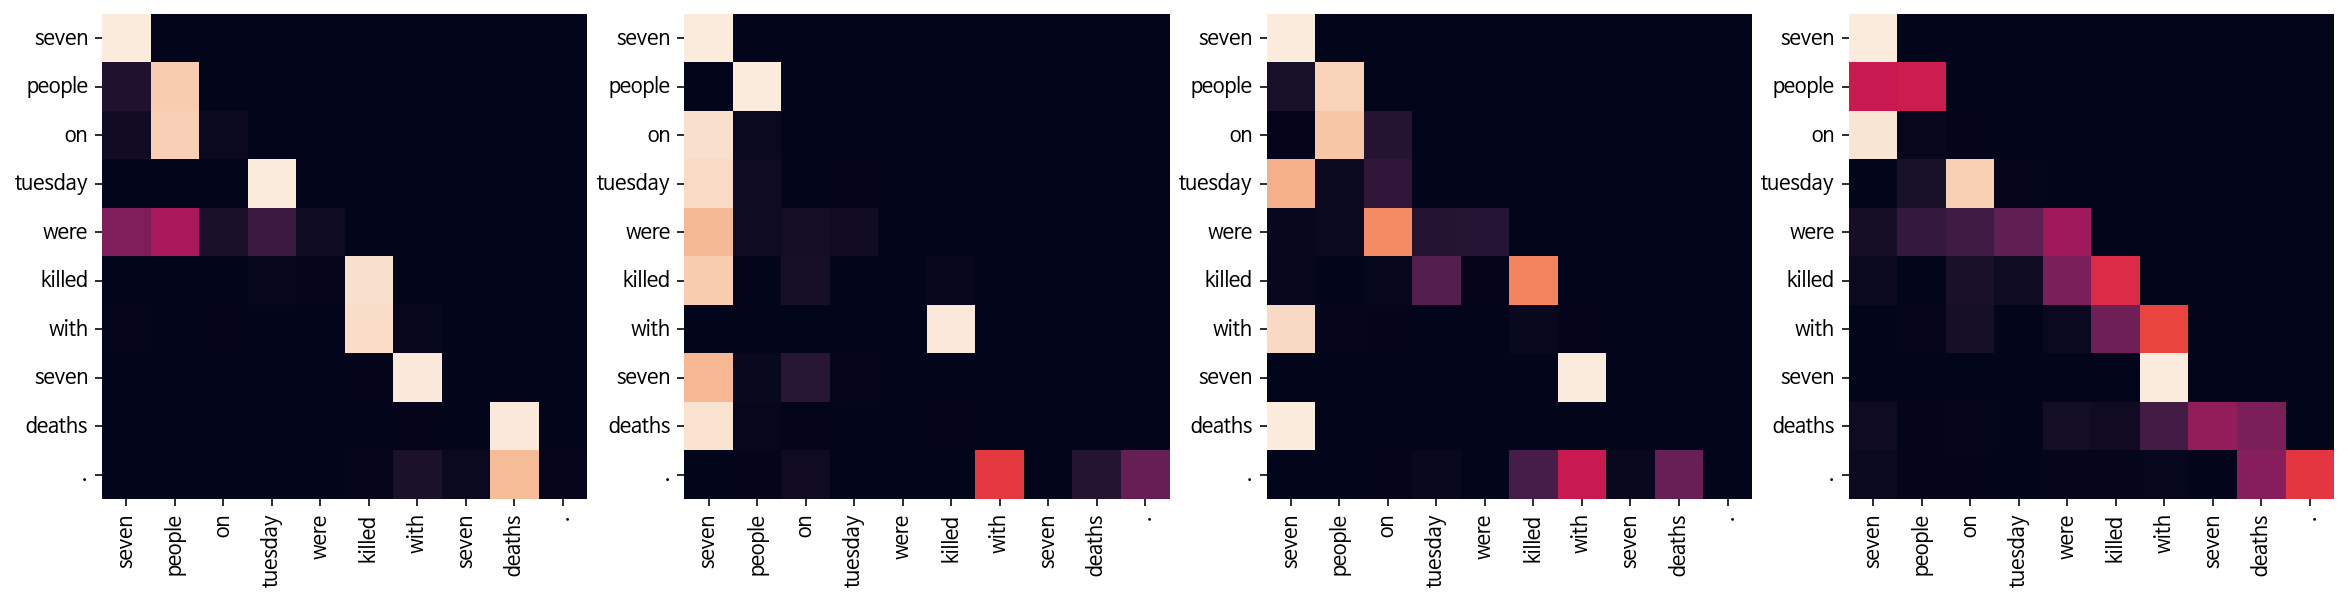

Decoder Src Layer 1


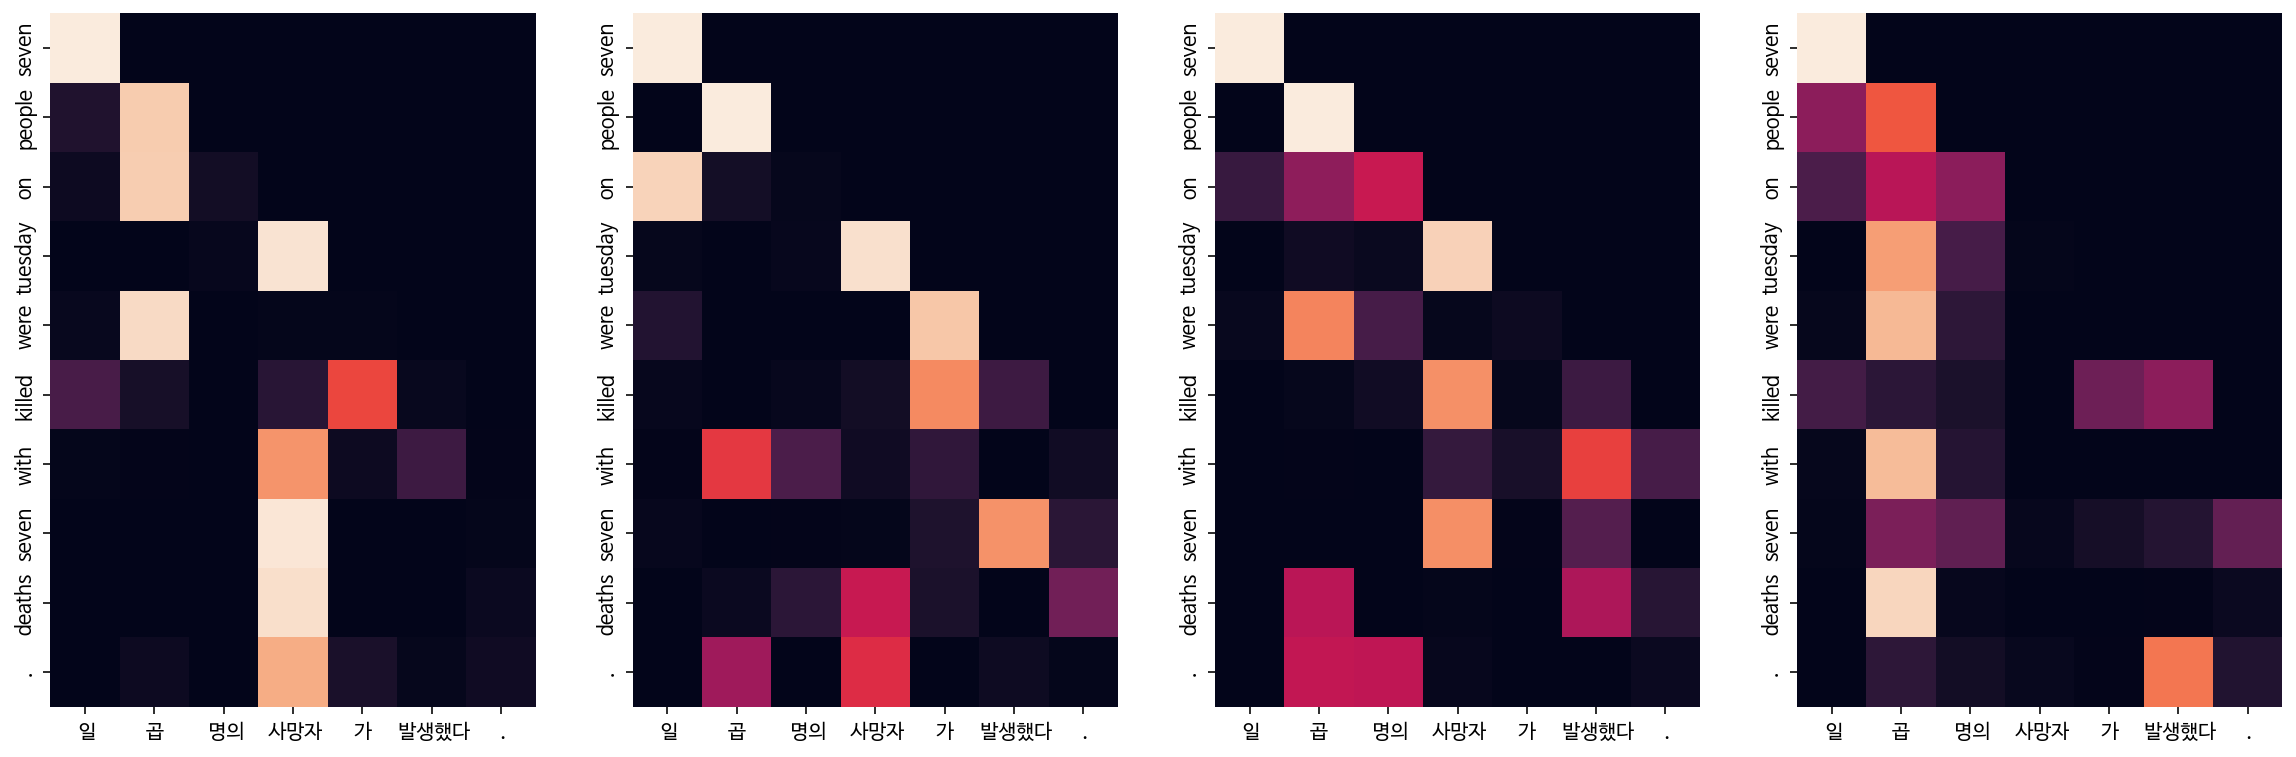

Decoder Self Layer 2


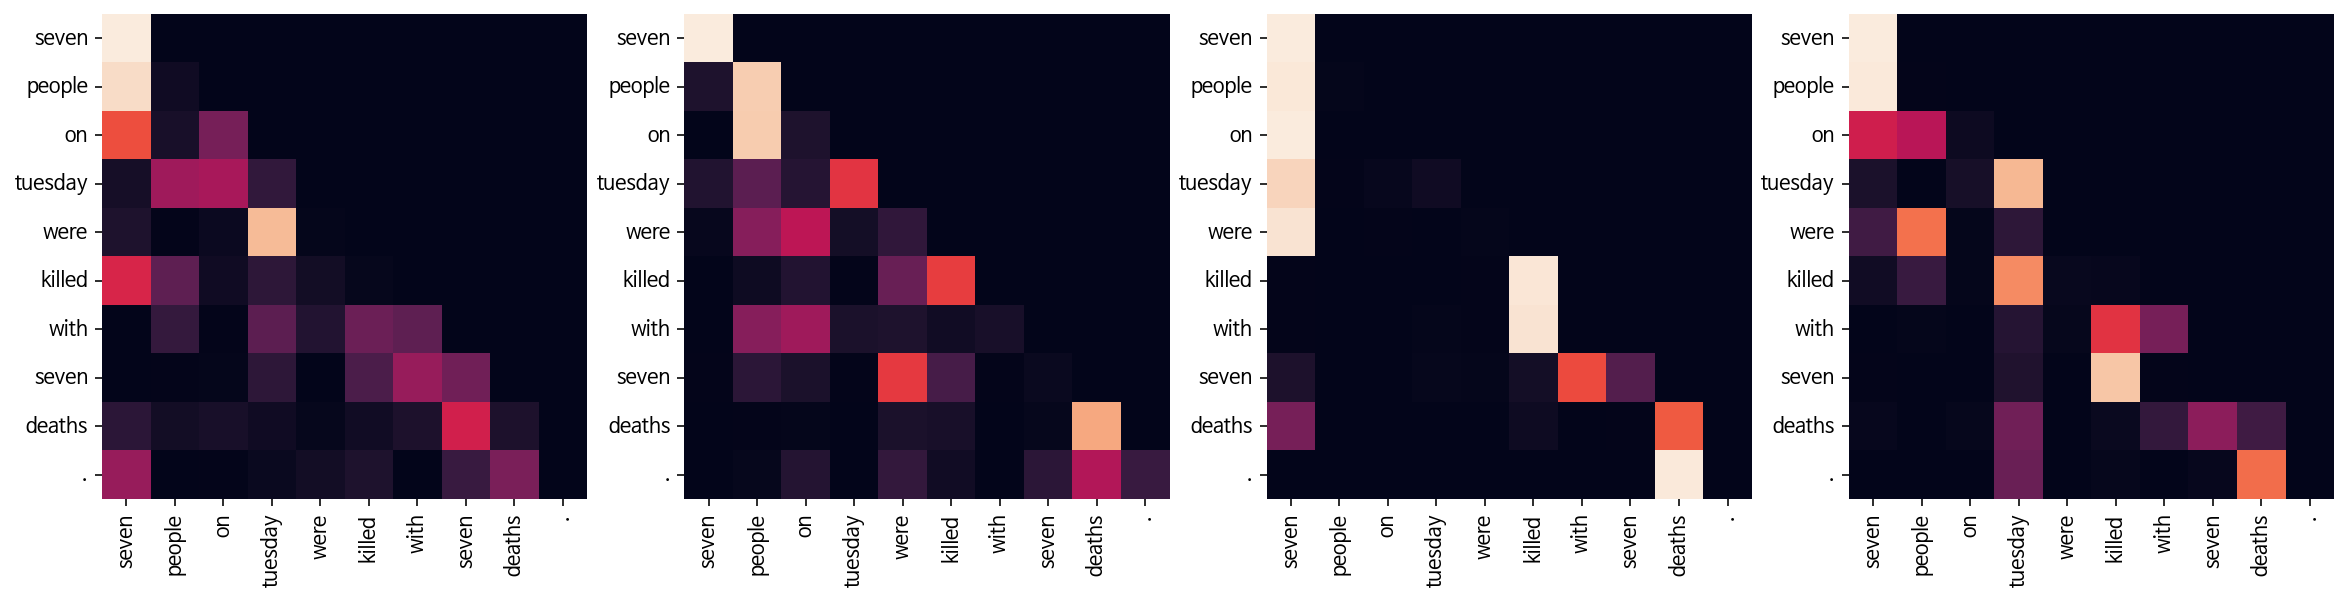

Decoder Src Layer 2


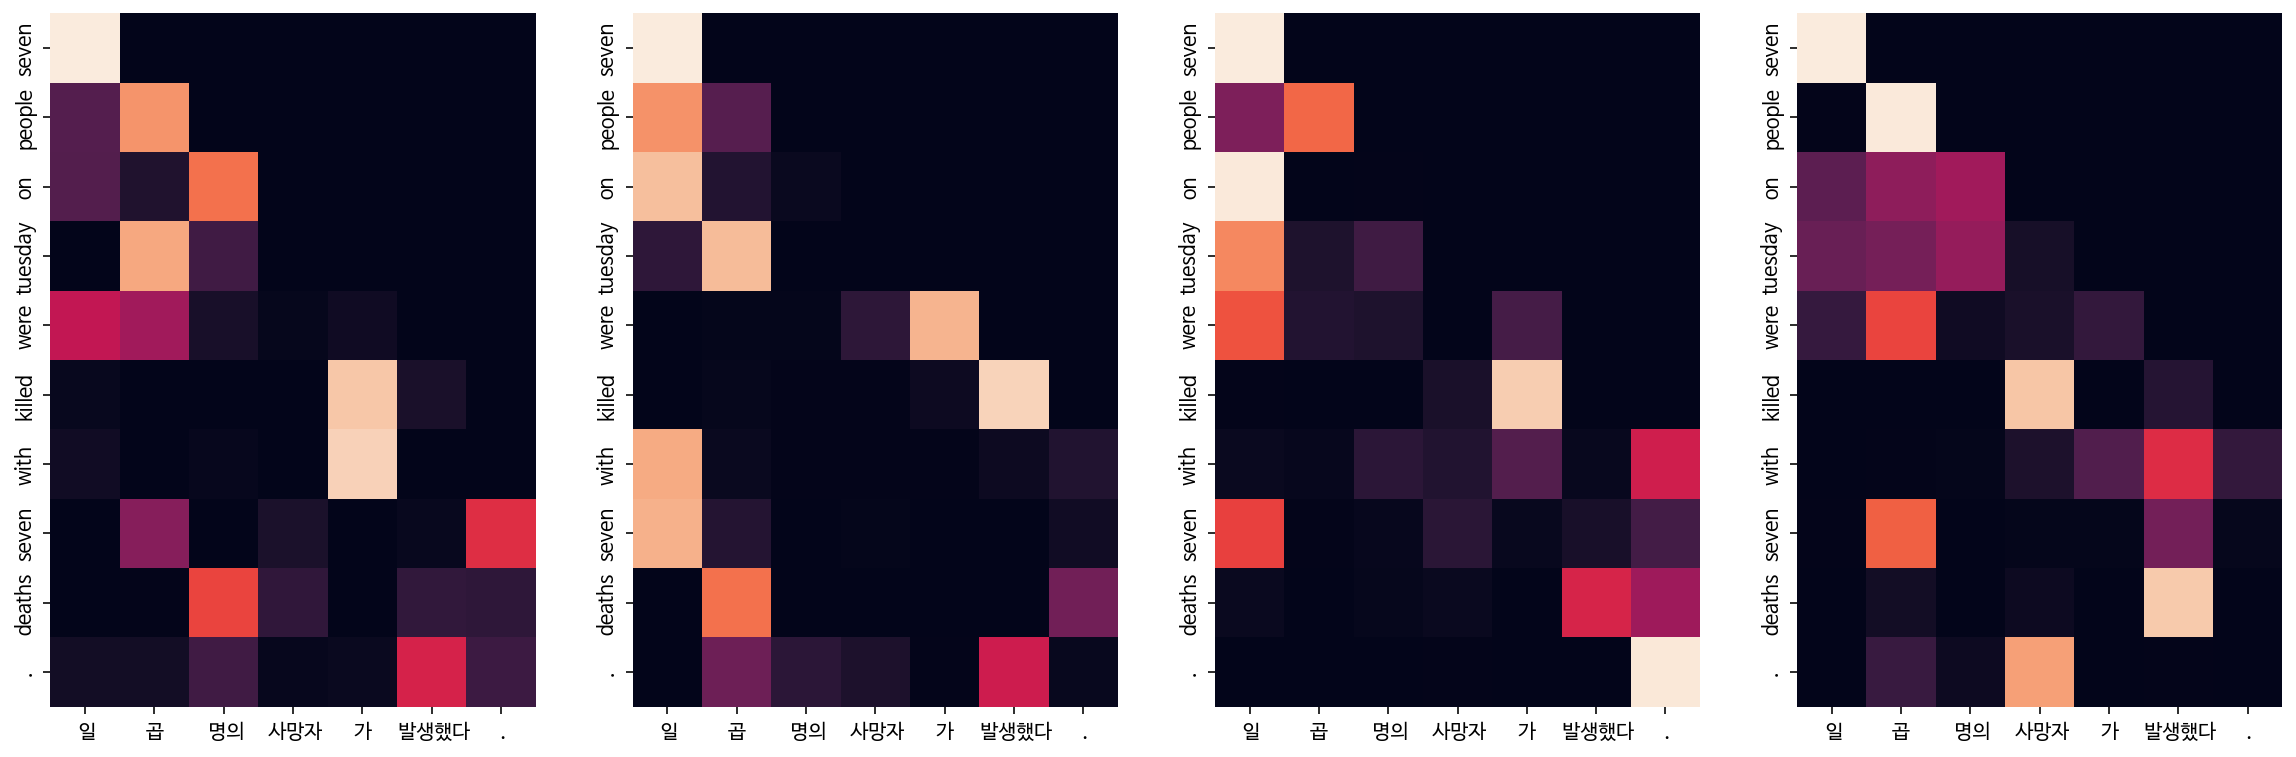

In [36]:
for example in examples:
    translate(example, transformer, ko_tokenizer, en_tokenizer, plot_attention=True)

### 결론

먼저 텍스트 결과를 살펴보자.

Input: 오바마는 대통령이다.
Predicted translation: obama is president of the country .
이상한 수식어구가 생겼지만, 의미는 통한다고 볼 수 있다.

Input: 시민들은 도시 속에 산다.
Predicted translation: they stay in the town .
직접적이진 않지만, 의미상 동일한 의미로 번역되었다.

Input: 커피는 필요 없다.
Predicted translation: there need to be needed .
가장 중요한 커피라는 단어가 사라졌다.

Input: 일곱 명의 사망자가 발생했다.
Predicted translation: seven people on tuesday were killed with seven deaths .
불필요한 수식어가 추가됬지만, 의미는 재대로 전달했다.

어텐션 맵을 보면, 번역결과가 좋은 문장의 디코더 어텐션 맵이 단위행렬과 같은 대각선 모양을 형성하고 있다. 
또한 밝은 색을 보여서 재대로 주목을 잘 했음을 알 수 있다.

이러한 근거를 통해 나는 모델이 어느정도 성능이 잘 나온다고 평가한다.